<a href="https://colab.research.google.com/github/shuntaro0628/Optimization_Project_8parameters/blob/main/NN_pls_Genetic_for_Focusing_v3_0_50kW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="skyblue">***NN + Genetic for FieldFocusing V3.0. 50kW***</font><br>

Ver.1.0. (August 16, 2021): Code for double-sided LCCL is modified for magnetic focusing circuit. 

Ver. 3.0.: (March 1, 2021): A function that NN model can be saved and loaded has been added.



# User input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Import libraries
import torch
from torch import tensor
from torch import nn 
from torch import sigmoid
from torch import atan
from torch import tanh
import pandas as pd
import numpy as np
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Import FEM data
foldername ='/content/drive/My Drive/2021_Spring/Maxwell/DWPT_8parameters/Output_csv/v4/' 
filename = 'result_all'

df = pd.read_csv(foldername+filename+'.csv')

df.to_csv(foldername+'/alldata.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,CoilLoss_xs0[W],kdiff[%],Pripple[%],Pave[W/m],Bstray[uT(rms)],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],V_PriWind[m3],V_SecWind[m3],V_PriCore[m3],V_SecCore[m3],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH],Lp_xs1_ys0[nH],Ls_xs1_ys0[nH],Bx_p_xs0_0deg[uT],By_p_xs0_0deg[uT],Bz_p_xs0_0deg[uT],Bx_p_xs0_90deg[uT],By_p_xs0_90deg[uT],Bz_p_xs0_90deg[uT],Bx_s_xs0_0deg[uT],By_s_xs0_0deg[uT],Bz_s_xs0_0deg[uT],Bx_s_xs0_90deg[uT],By_s_xs0_90deg[uT],Bz_s_xs0_90deg[uT],Bx_p_xs1_0deg[uT],By_p_xs1_0deg[uT],Bz_p_xs1_0deg[uT],Bx_p_xs1_90deg[uT],By_p_xs1_90deg[uT],Bz_p_xs1_90deg[uT],Bx_s_xs1_0deg[uT],By_s_xs1_0deg[uT],Bz_s_xs1_0deg[uT],Bx_s_xs1_90deg[uT],By_s_xs1_90deg[uT],Bz_s_xs1_90deg[uT]
0,0,0.002257,68.356983,95.422612,0.022658,0.106552,126.467048,63.830496,1203.379407,143.703834,29.358534,271.843869,212.005632,164.330553,2364.441725,2571.535375,2778.629026,2985.722677,3192.816327,0.006018,0.001336,0.007001,0.001638,0.078768,0.079275,0.074486,0.040101,0.001793,0.024925,1287.789133,1287.154988,1301.180581,1305.685823,1307.974825,402.975068,401.793529,403.806794,401.086988,404.867110,1305.181986,400.217929,-0.00368,0.000114,-0.03060,-0.000006,-1.870000e-07,0.000023,3.770000e-07,-6.360000e-08,-8.270000e-07,0.00246,0.000015,0.00422,0.02950,-0.000180,-0.1020,-0.000018,-4.020000e-07,0.000010,4.960000e-06,2.400000e-08,-0.000003,-0.004450,-1.910000e-05,0.00762
1,1,0.001737,42.357168,68.981733,0.029647,0.147215,134.259701,407.113730,194.824980,140.672269,38.135282,121.512055,169.658217,178.086977,754.518294,826.052881,897.587468,969.122055,1040.656642,0.001768,0.001499,0.002453,0.001781,0.140722,0.126999,0.094762,0.055997,0.021601,0.081116,901.482522,901.233756,905.140502,913.396622,924.605296,399.633858,398.503716,397.361564,398.197751,397.747811,911.144339,395.857890,0.01510,0.000568,-0.02590,-0.000013,-7.760000e-07,0.000003,1.680000e-06,-6.590000e-08,-1.050000e-06,-0.00159,0.000061,0.00635,0.05180,0.000584,-0.1360,-0.000063,7.850000e-07,0.000004,7.070000e-06,-1.170000e-07,-0.000005,-0.016500,-1.410000e-04,0.01470
2,2,0.002774,38.029657,97.370858,0.079899,0.167992,86.747440,315.951623,351.708168,340.112135,134.577857,219.295014,282.216631,185.359624,1367.681686,1499.021597,1630.361507,1761.701418,1893.041329,0.003829,0.002571,0.004251,0.003287,0.285703,0.244285,0.146499,0.050646,-0.003740,0.177051,1004.247455,1004.004974,1002.872144,1014.183288,1013.400523,1073.229614,1061.073603,1040.880349,1047.181252,1072.256518,998.872835,1051.836948,-0.00628,0.000034,-0.03590,-0.000010,1.780000e-07,0.000005,7.670000e-06,4.760000e-08,1.530000e-07,-0.00143,-0.000585,0.02450,0.01650,0.000558,-0.1510,-0.000044,-1.000000e-06,0.000002,1.060000e-05,5.970000e-07,-0.000006,-0.046000,5.630000e-04,0.05500
3,3,0.003367,43.240726,67.148384,0.095836,0.453141,168.535216,274.894556,878.066054,264.082441,117.290437,258.178295,78.087389,210.081146,1629.607990,1773.549399,1917.490808,2061.432216,2205.373625,0.003808,0.002630,0.005835,0.003075,0.206689,0.200247,0.167328,0.101578,0.033262,0.117315,1720.960222,1744.133870,1771.214042,1776.979511,1785.053794,800.797264,799.462190,800.054013,797.956431,804.341937,1737.671588,780.951757,0.05330,0.000694,-0.07180,-0.000034,1.200000e-07,0.000013,7.830000e-06,4.580000e-08,-1.250000e-06,-0.00647,-0.000205,0.02190,0.11600,0.002340,-0.4310,-0.000122,5.310000e-07,0.000093,1.250000e-05,-2.440000e-07,-0.000013,-0.032000,2.520000e-04,0.07110
4,4,0.002394,50.335915,95.082938,0.036956,0.040166,27.487650,256.836000,189.041904,329.267104,47.927559,97.017950,291.631852,98.315765,1060.570045,1163.099191,1265.628337,1368.157483,1470.686629,0.001978,0.001110,0.001953,0.001959,0.157979,0.135166,0.082172,0.027364,-0.003865,0.078459,668.644938,667.704268,668.449282,670.898715,668.728297,1124.470286,1119.623127,1118.585743,1121.

# Define training and validation data

In [ ]:
# Initialize RNG except to PyTorch
import random
import statistics
seed = 111#333#888#555#777#666 
random.seed(seed)  
np.random.seed(seed)  
# Initialize RNG of PyTorch 
torch.manual_seed(seed)  

# Defining Training data
x_df = df.loc[:, 'ax[mm]':'ys4[mm]']
y1_df = df.loc[:, 'k_xs0_ys0':'Ls_xs1_ys0[nH]']
y2_df = df.loc[:, 'Bx_p_xs0_0deg[uT]':'Bz_s_xs1_90deg[uT]']
y_df = pd.concat([y1_df,y2_df],axis=1)

x_np=0
y_np=0
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x_np = x_df.values
y_np = y_df.values

def min_max(x_sample, x, axis=0):# axis=0 is vertical direction.
    min_x = x_sample.min(axis=axis, keepdims=True)
    max_x = x_sample.max(axis=axis, keepdims=True)
    result = (x-min_x)/(max_x-min_x)
    return result

def inv_min_max(x_sample, x_std, axis=0):
    min_x = x_sample.min(axis=axis, keepdims=True)
    max_x = x_sample.max(axis=axis, keepdims=True)    
    result = x_std*(max_x-min_x)+min_x
    return result

x_np_std = min_max(x_np, x_np)
y_np_std = min_max(y_np, y_np)

cls=['k_xs0_ys0','k_xs0_ys1', 'k_xs0_ys2', 'k_xs0_ys3', 'k_xs0_ys4', 'k_xs1_ys0',\
 'Lp_xs0_ys0[nH]', 'Lp_xs0_ys1[nH]', 'Lp_xs0_ys2[nH]', 'Lp_xs0_ys3[nH]', 'Lp_xs0_ys4[nH]',\
 'Ls_xs0_ys0[nH]', 'Ls_xs0_ys1[nH]', 'Ls_xs0_ys2[nH]', 'Ls_xs0_ys3[nH]','Ls_xs0_ys4[nH]',\
 'Lp_xs1_ys0[nH]', 'Ls_xs1_ys0[nH]',\
 'Bx_p_xs0_0deg[uT]',  'By_p_xs0_0deg[uT]',  'Bz_p_xs0_0deg[uT]',\
 'Bx_p_xs0_90deg[uT]', 'By_p_xs0_90deg[uT]', 'Bz_p_xs0_90deg[uT]',\
 'Bx_s_xs0_0deg[uT]',  'By_s_xs0_0deg[uT]',  'Bz_s_xs0_0deg[uT]',\
 'Bx_s_xs0_90deg[uT]', 'By_s_xs0_90deg[uT]', 'Bz_s_xs0_90deg[uT]',\
 'Bx_p_xs1_0deg[uT]',  'By_p_xs1_0deg[uT]',  'Bz_p_xs1_0deg[uT]',\
 'Bx_p_xs1_90deg[uT]', 'By_p_xs1_90deg[uT]', 'Bz_p_xs1_90deg[uT]',\
 'Bx_s_xs1_0deg[uT]',  'By_s_xs1_0deg[uT]',  'Bz_s_xs1_0deg[uT]',\
 'Bx_s_xs1_90deg[uT]', 'By_s_xs1_90deg[uT]', 'Bz_s_xs1_90deg[uT]'] 

df_y_std      = pd.DataFrame(y_np_std[:,:42], columns=cls)

df_y_std.to_csv(foldername+'/alldata_std.csv')

df_y_std

,k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH],Lp_xs1_ys0[nH],Ls_xs1_ys0[nH],Bx_p_xs0_0deg[uT],By_p_xs0_0deg[uT],Bz_p_xs0_0deg[uT],Bx_p_xs0_90deg[uT],By_p_xs0_90deg[uT],Bz_p_xs0_90deg[uT],Bx_s_xs0_0deg[uT],By_s_xs0_0deg[uT],Bz_s_xs0_0deg[uT],Bx_s_xs0_90deg[uT],By_s_xs0_90deg[uT],Bz_s_xs0_90deg[uT],Bx_p_xs1_0deg[uT],By_p_xs1_0deg[uT],Bz_p_xs1_0deg[uT],Bx_p_xs1_90deg[uT],By_p_xs1_90deg[uT],Bz_p_xs1_90deg[uT],Bx_s_xs1_0deg[uT],By_s_xs1_0deg[uT],Bz_s_xs1_0deg[uT],Bx_s_xs1_90deg[uT],By_s_xs1_90deg[uT],Bz_s_xs1_90deg[uT]
0,0.225915,0.248801,0.306186,0.299098,0.175665,0.101676,0.172093,0.172008,0.174190,0.173452,0.172859,0.153637,0.152520,0.153355,0.152380,0.153931,0.172154,0.151350,0.238681,0.512645,0.965945,0.781387,0.566528,0.094410,0.103350,0.552567,0.745190,0.639906,0.322350,0.028890,0.867942,0.437073,0.921709,0.701874,0.438372,0.278413,0.380689,0.461446,0.776492,0.532655,0.331098,0.027425
1,0.410768,0.404700,0.393455,0.386593,0.313765,0.320527,0.113320,0.113247,0.113859,0.114149,0.115306,0.151866,0.150779,0.149949,0.150852,0.150180,0.112904,0.149052,0.285607,0.537714,0.971246,0.759038,0.544302,0.034750,0.137995,0.551983,0.737893,0.608091,0.328769,0.044480,0.881481,0.455707,0.895330,0.597190,0.463152,0.266956,0.436201,0.440211,0.725507,0.475627,0.321736,0.054075
2,0.843347,0.787835,0.616134,0.357141,0.137086,0.694166,0.128954,0.128895,0.128747,0.129385,0.128637,0.508927,0.501373,0.489986,0.494112,0.505578,0.126096,0.494795,0.232184,0.508233,0.959967,0.770330,0.580302,0.041169,0.297261,0.580800,0.777258,0.609348,0.238462,0.177327,0.860049,0.455073,0.883692,0.640749,0.425887,0.264723,0.529071,0.547741,0.709886,0.336015,0.375806,0.205770
3,0.607595,0.643979,0.705781,0.637474,0.395061,0.461513,0.237997,0.241587,0.245793,0.244699,0.244481,0.364515,0.362943,0.362733,0.362292,0.364414,0.237187,0.352021,0.381059,0.544671,0.919475,0.689808,0.578113,0.063541,0.301516,0.580343,0.731348,0.569756,0.291608,0.158296,0.920461,0.498537,0.666455,0.459016,0.457850,0.431734,0.579058,0.421084,0.555412,0.402272,0.351920,0.266372
4,0.462258,0.431380,0.339266,0.228993,0.136220,0.310178,0.077895,0.077690,0.077802,0.077490,0.076893,0.536088,0.532355,0.531046,0.533506,0.538922,0.076439,0.536629,0.207896,0.499172,0.990060,0.792242,0.560868,0.032367,0.157139,0.643866,0.789300,0.673998,0.324070,0.097545,0.836126,0.438293,0.980130,0.725972,0.459395,0.256089,0.421731,0.419277,0.872604,0.526124,0.356605,0.068379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4694,0.198379,0.206712,0.220707,0.271708,0.266531,0.229221,0.264801,0.267100,0.270255,0.274463,0.274122,0.024898,0.024819,0.024938,0.024908,0.025746,0.269361,0.024764,0.695152,0.523578,0.764725,0.295262,0.518491,0.136282,0.270141,0.573945,0.526832,0.584289,0.310685,0.043894,0.528233,0.414390,0.352236,0.608197,0.523591,0.857934,0.237253,0.442470,0.466459,0.559205,0.342089,0.051064
4695,0.466215,0.487977,0.560217,0.653495,0.645483,0.383195,0.044605,0.044218,0.044535,0.043477,0.043354,0.492427,0.491646,0.493771,0.499320,0.498823,0.043776,0.483494,0.342079,0.531143,0.967186,0.757694,0.566038,0.010025,0.367190,0.466397,0.602749,0.421053,0.357063,0.314199,0.877717,0.423488,0.854986,0.648946,0.458330,0.337454,0.510655,0.467229,0.485985,0.308566,0.277650,0.537013
4696,0.250593,0.279159,0.338173,0.320508,0.178161,0.094359,0.276064,0.276274,0.278511,0.277341,0.275486,0.134423,0.133801,0.133689,0.132700,0.134428,0.274135,0.134744,0.189905,0.499503,0.973728,0.764079,0.562717,0.072710,0.064079,0.553735,0.713678,0.664886,0.323930,0.037892,0.845094,0.413171,0.951812,0.701405,0.456242,0.272768,0.299395,0.443358,0.806649,0.551907,0.328303,0.026786
4697,0.096437,0.106779,0.145778,0.200826,0.147319,0.047683,0.361268,0.360657,0.361023,0.360569

In [ ]:
x_tensor=torch.tensor(x_np_std)
y_tensor=torch.tensor(y_np_std)

# Deviding to training and validation data
n_samples = x_tensor.shape[0]#Get the shape of the data, [150, 1] and output first one, 150. 
n_val = int(0.022*n_samples)
shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:n_samples-n_val]
val_indices = shuffled_indices[n_samples-n_val:]

x_train = x_tensor[train_indices]
y_train = y_tensor[train_indices]
x_val = x_tensor[val_indices]
y_val = y_tensor[val_indices]

x_train  = x_train.to(device)
x_train  = x_train.to(dtype)
x_val  = x_val.to(device)
x_val  = x_val.to(dtype)

y_train = y_train.to(device)
y_train = y_train.to(dtype)
y_val = y_val.to(device)
y_val = y_val.to(dtype)
# shape(y_val)

# Neural network process

## STEP 1: Designing model

In [ ]:
# STEP 1: Design your model using class
class Model(nn.Module):
  def __init__(self):
    #In the constructor, we instantiate nn.Linear module.
    super(Model, self).__init__()
    self.linear1 = nn.Linear(13, 100, bias=True).cuda() # nn.Linear(<input size> ,<output size>)
    self.linear2 = nn.Linear(100,100, bias=True).cuda()
    # self.linear3 = nn.Linear(100, 33, bias=True).cuda()
    # self.linear3 = nn.Linear(100, 30, bias=True).cuda()
    self.linear3 = nn.Linear(100, 42, bias=True).cuda()


  def forward(self, x):
    x = atan(self.linear1(x))# 
    x = atan(self.linear2(x))
    x = atan(self.linear2(x))
    # x = self.linear1(x)# 
    # x = self.linear2(x)
    # x = self.linear2(x)
    # x = sigmoid(self.linear1(x))
    # x = sigmoid(self.linear2(x))
    # x = sigmoid(self.linear2(x))   
    # x = tanh(self.linear1(x))  
    # x = tanh(self.linear2(x))
    # x = tanh(self.linear2(x)) 
    y_pred = self.linear3(x)
    return y_pred
# our model
model=Model() 

## STEP 2: Construct loss and optimizer

In [ ]:
# STEP 2: Construct loss and optimizer
# Construct our loss function and an Optimizer. The call to model. parameters()
# in the SGD constructor will contain the learnable parameters of the two 
# nn.Linear moduled which are members of the model.
# criterion_L1 = nn.L1Loss(reduction='mean') 
criterion_L2 = nn.MSELoss(reduction='mean') 
# criterion = nn.MAPELoss(reduction='mean') 
#size_avarage define whethere devide by bach-size or not.
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9, dampening=0.0, weight_decay=0.0,nesterov=False)# atan
# optimizer = optim.SGD(model.parameters(), lr=0.6, momentum=0.9, dampening=0.0, weight_decay=0.0,nesterov=False)# tanh
# optimizer = optim.SGD(model.parameters(), lr=0.6, momentum=0.9, dampening=0.0, weight_decay=0.0,nesterov=False)# tanh
# optimizer = optim.SGD(model.parameters(), lr=3, momentum=1, dampening=0.0, weight_decay=0.0,nesterov=False)#lr=1.0

# optimizer = optim.SGD(model.parameters(), lr=4, momentum=0.0, dampening=0.0, weight_decay=0.0,nesterov=False)#lr=1.0


## STEP 3: Training cycle

In [ ]:
# STEP 3: Training cycle (forward, backward, update)
import math
# n_epochs = 170000#
n_epochs = 340000# Minimum error
# n_epochs = 500000#
# n_epochs = 1000#340000#1000000

loss_train_history=[]
loss_val_history=[]
loss_val_2_history=[]
loss_val_3_history=[]
loss_val_MAPE_history=[]
# loss_val_SMAPE_history=[]

loss_val_k_xs0_ys0_history=[]
loss_val_k_xs0_ys1_history=[]
loss_val_k_xs0_ys2_history=[]
loss_val_k_xs0_ys3_history=[]
loss_val_k_xs0_ys4_history=[]
loss_val_k_xs1_ys0_history=[]

loss_val_Lp_xs0_ys0_history=[]
loss_val_Lp_xs0_ys1_history=[]
loss_val_Lp_xs0_ys2_history=[]
loss_val_Lp_xs0_ys3_history=[]
loss_val_Lp_xs0_ys4_history=[]
loss_val_Lp_xs1_ys0_history=[]

loss_val_Ls_xs0_ys0_history=[]
loss_val_Ls_xs0_ys1_history=[]
loss_val_Ls_xs0_ys2_history=[]
loss_val_Ls_xs0_ys3_history=[]
loss_val_Ls_xs0_ys4_history=[]
loss_val_Ls_xs1_ys0_history=[]

loss_val_Bp_xs0_ys0_history=[]
loss_val_Bs_xs0_ys0_history=[]
loss_val_Bp_xs1_ys0_history=[]
loss_val_Bs_xs1_ys0_history=[]

loss_val_kdiff_history=[]
loss_val_Pripple_history=[]
loss_val_Pave_history=[]
loss_val_CoilLoss_history=[]
loss_val_Bstray_history=[]

loss_val_Bx_p_xs0_0deg_history = []
loss_val_By_p_xs0_0deg_history = []
loss_val_Bz_p_xs0_0deg_history = []
loss_val_Bx_p_xs0_90deg_history = []
loss_val_By_p_xs0_90deg_history = []
loss_val_Bz_p_xs0_90deg_history = []

loss_val_Bx_s_xs0_0deg_history = []
loss_val_By_s_xs0_0deg_history = []
loss_val_Bz_s_xs0_0deg_history = []
loss_val_Bx_s_xs0_90deg_history = []
loss_val_By_s_xs0_90deg_history = []
loss_val_Bz_s_xs0_90deg_history = []

loss_val_Bx_p_xs1_0deg_history = []
loss_val_By_p_xs1_0deg_history = []
loss_val_Bz_p_xs1_0deg_history = []
loss_val_Bx_p_xs1_90deg_history = []
loss_val_By_p_xs1_90deg_history = []
loss_val_Bz_p_xs1_90deg_history = []

loss_val_Bx_s_xs1_0deg_history = []
loss_val_By_s_xs1_0deg_history = []
loss_val_Bz_s_xs1_0deg_history = []
loss_val_Bx_s_xs1_90deg_history = []
loss_val_By_s_xs1_90deg_history = []
loss_val_Bz_s_xs1_90deg_history = []

def MAPE(x_true, x_pred, axis=0):
    result =  (x_pred-x_true).abs()/torch.max(x_true.abs(), x_pred.abs())
    return result
# def SMAPE(x_true, x_pred, axis=0):
#     result = (2* (x_pred-x_true).abs() / (x_pred.abs()+x_true.abs() )) #max(y_train[41])/100) )
#     return result

loss_val_Bstray=[]
m = len(y_train[:,0])
for epoch in range(n_epochs+1):
  # Forward pass: Compute predicted y by passing x to the model
  y_pred_train = model(x_train)
  loss_train = criterion_L2(y_pred_train[:,0:42], y_train[:,0:42]) 
  loss_train_history.append(loss_train.item())   

  y_pred_val =model(x_val)     
  loss_val = criterion_L2(y_pred_val[:,0:42], y_val[:,0:42])
  loss_val_history.append(loss_val.item())     

  loss_val_MAPE = torch.mean(MAPE(y_pred_val[:,:42], y_val[:,:42]))
  # loss_val_SMAPE = torch.mean(SMAPE(y_pred_val[:,:42], y_val[:,:42]))

  loss_val_MAPE_history.append(loss_val_MAPE.item())
  # loss_val_SMAPE_history.append(loss_val_SMAPE.item())
  
  if epoch ==1 or epoch % 10000 ==0:      

    print(f'Epoch {epoch}/{n_epochs} | Training L2 error [%]: {(loss_train.item())**0.5*100: .4f} | Validation L2 error [%]: {(loss_val.item())**0.5*100: .4f} \
    | Validation MAPE [%]: {(loss_val_MAPE.item())*100: .4f}') 
   
  # Zero gradients, perform a backward pass, and update the weights.
  optimizer.zero_grad() 
  loss_train.backward()

  optimizer.step()


Epoch 0/340000 | Training L2 error [%]:  48.6957 | Validation L2 error [%]:  49.1433     | Validation MAPE [%]:  104.4897
Epoch 1/340000 | Training L2 error [%]:  44.0100 | Validation L2 error [%]:  44.5103     | Validation MAPE [%]:  93.5548
Epoch 10000/340000 | Training L2 error [%]:  2.8774 | Validation L2 error [%]:  3.0650     | Validation MAPE [%]:  5.6316
Epoch 20000/340000 | Training L2 error [%]:  2.6639 | Validation L2 error [%]:  2.9019     | Validation MAPE [%]:  4.9056
Epoch 30000/340000 | Training L2 error [%]:  2.5729 | Validation L2 error [%]:  2.8324     | Validation MAPE [%]:  4.4545
Epoch 40000/340000 | Training L2 error [%]:  2.5200 | Validation L2 error [%]:  2.7823     | Validation MAPE [%]:  4.1635
Epoch 50000/340000 | Training L2 error [%]:  2.4846 | Validation L2 error [%]:  2.7473     | Validation MAPE [%]:  3.9377
Epoch 60000/340000 | Training L2 error [%]:  2.4583 | Validation L2 error [%]:  2.7232     | Validation MAPE [%]:  3.8175
Epoch 70000/340000 | Trai

## STEP 4: Cheaking accuracy

### Plotting error curves

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6484 sha256=e4adaf437d1cd30e94d82da2a3ac587566d0dcb8d06e469e807ea5131b641d0c
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff84bbbc3d0> has a label of '_line0' which cannot be automatically added to the legend.


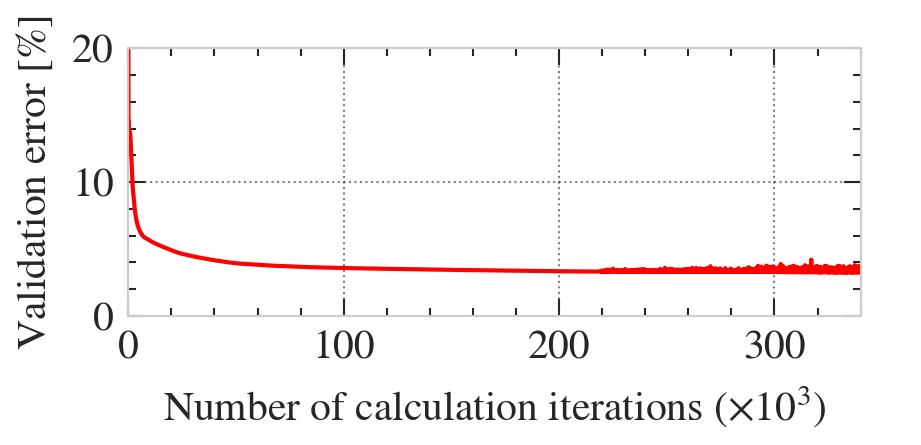

In [ ]:
# User input
# Setting for APEC 
!pip install SciencePlots
import matplotlib
import matplotlib.pyplot as plt
plt.style.reload_library()

# User input
  # Setting for APEC 
fig_width = 8 #cm
fig_height = 3 #cm
font_size = 10 # pt

import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *

path = '/content/drive/My Drive/Improving/Python_cards/matplot/SciencePlots-master/styles/'
plt.style.use('seaborn-whitegrid')
plt.style.use([path+'misc/grid.mplstyle'])
plt.style.use([path+'journals/ieee.mplstyle'])
plt.style.use(['science','no-latex'])# ref: https://github.com/garrettj403/SciencePlots 

# Update the matplotlib configuration parameters:
# A good choice of global fonts are the STIX fonts:
# Ref: https://notebook.community/ondrolexa/sg2/02_Scientific_Python_matplotlib
matplotlib.rcParams.update({'font.size': font_size, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

def cm2inch(value):
    return value/2.54
fig1=plt.figure(figsize=(cm2inch(fig_width),cm2inch(fig_height)), dpi=300)

epoch=[]
for i in range(n_epochs+1):
  epoch.append(i/1000)

arr_loss_train = np.array(loss_train_history)
arr_loss_val = np.array(loss_val_history)
arr_loss_val_MAPE = np.array(loss_val_MAPE_history)

train_loss=[]
val_loss=[]
val_loss_k_xs0_ys0=[]
val_loss_k_xs0_ys1=[]
val_loss_k_xs0_ys2=[]
val_loss_k_xs0_ys3=[]
val_loss_k_xs0_ys4=[]
val_loss_k_xs1_ys0=[]

val_loss_Lp_xs0_ys0=[]
val_loss_Lp_xs0_ys1=[]
val_loss_Lp_xs0_ys2=[]
val_loss_Lp_xs0_ys3=[]
val_loss_Lp_xs0_ys4=[]

val_loss_Ls_xs0_ys0=[]
val_loss_Ls_xs0_ys1=[]
val_loss_Ls_xs0_ys2=[]
val_loss_Ls_xs0_ys3=[]
val_loss_Ls_xs0_ys4=[]

val_loss_Lp_xs1_ys0=[]
val_loss_Ls_xs1_ys0=[]

val_loss_Bp_xs0_ys0=[]
val_loss_Bs_xs0_ys0=[]
val_loss_Bp_xs1_ys0=[]
val_loss_Bs_xs1_ys0=[]

val_loss_CoilLoss=[]
val_loss_kdiff=[]
val_loss_Pripple=[]
val_loss_Pave=[]
val_loss_Bstray=[]

lw = 0.5

# p1,=plt.plot(epoch,(arr_loss_train)**0.5*100, "b-", linewidth=1, label="Training error")
# p2,=plt.plot(epoch,(arr_loss_val)**0.5*100, "r--", linewidth=1, label="Validation error")
# p3,=plt.plot(epoch,(arr_loss_val_MAPE)*100, "r-", linewidth=1, label="Validation error")
p3,=plt.plot(epoch,(arr_loss_val_MAPE)*100, "r-", linewidth=1)

# plt.legend(handles=[p1,p2,p3],bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0,frameon=True,fontsize=5)
plt.legend(handles=[p3],bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0,fontsize=5)
 
plt.xlabel(r"Number of calculation iterations ($\times 10^3$)") 
# plt.ylabel(r"RMSE [$\%$]")   
plt.ylabel(r"Validation error [$\%$]")            

plt.axis([0, n_epochs/1000, 0, 20])
plt.tick_params(axis ='both', which ='major', length = 4, direction = 'in') 
plt.tick_params(axis ='both', which ='minor', length = 2, direction = 'in') 
fig_update = True
# fig1.savefig("/content/drive/MyDrive/2021_Spring/Report/Shun/ECCE2021_digest/FIG/Error_curves.pdf")

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/2022_Spring/Python/FocusingOptimization/Fitting/saved_model_for_8parameters.pt')#https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/6
model.load_state_dict(torch.load('/content/drive/MyDrive/2022_Spring/Python/FocusingOptimization/Fitting/saved_model_for_8parameters.pt'))

<All keys matched successfully>

## Generating random input

In [ ]:
##### Plot ###### 
#Make spec data in equal intervals
import pandas as pd
import numpy as np

df = pd.read_csv(foldername+filename+'.csv')
import random
seed = 5586 #5587#5586#5584#5583#5582#5581#5580#5576#5572#5571#5568 #5562 #5567#5563#5560#5557#5553#5552#5551#333#555#666 #777#888  
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed)  

# N=500
# N=100000
# N=500000
# N=2000000
N=3000000
# N=20000
# dp=6.6 #mm
# ds=6.6 #mm

Np_min = 3#2 # 3 #4 #turn
Np_max = 4#5#6#5 # 8 #turn
Ns_min = 3 # 3 #7 #turn
Ns_max = 4#5#6 # 8 #14 #turn

lpy_min = 700#50 #mm
lpy_max = 1200#2050 #mm
lpx_min = 50 #mm
lpx_max = 650 #mm
wpy_min = 25 # mm wpy = dp*Np 
wpy_max = 325 # mm
wpx_min = 25 # mm  wpx = dp*Np ~ 325
wpx_max = 325 # mm
ax_min = 0 # mm
ax_max = 200 # mm
ay_min = 0 # mm
ay_max = 0 # mm
p_min = 0 # mm
# p_max = 50 # mm
p_max = 50#200 # mm
ls_min = 250#200#50 # mm
ls_max = 400#450 # mm
ws_min = 100#25 # mm
ws_max = 200#225 # mm
# Ip_min = 190#150 # A rms  150
# Ip_max = 250 #200 # A rms
alpha = 2 # A/mm2 Conservative assumption 
Ip=[]
Np=[]
Ns=[]
dp = []
ax=[]
lpx=[]
lpy=[]
ls=[]
p=[]
wpx=[]
wpy=[]
ws=[]
ys0=[]
ys1=[]
ys2=[]
ys3=[]
ys4=[]

df_x_N = pd.DataFrame(index=[], columns=[])

import math
for i in range(N):      
  
  Np_i = round(random.uniform(Np_min, Np_max),0)
  Ns_i = round(random.uniform(Ns_min, Ns_max),0)
  # Ip_i = random.uniform(Ip_min, Ip_max) #A(rms)
  dp_i = 12 # [mm] 2 * (Ip_i/(math.pi*alpha))**0.5
  # wpy_i = random.uniform(dp * Np_i, wpy_max)
  wpy_i = dp_i * Np_i
  wpx_i = random.uniform(wpy_i, wpx_max)
  ax_i = random.uniform(ax_min, ax_max)
  ay_i = random.uniform(ay_min, ay_max)
  p_i   = random.uniform(p_min, p_max)
  lpx_i = 0
  while (lpx_i < lpx_min or lpx_max < lpx_i):
    lpx_i = round(random.uniform(lpx_min+2*ax_min+2*wpx_min, lpx_max+2*ax_max+2*wpx_max)/25,0)*25-2*ax_i-2*wpx_i    

  lpy_i = 0
  while (lpy_i < lpy_min or lpy_max < lpy_i):
    lpy_i = round(random.uniform(lpy_min+2*ay_min+2*wpy_min, lpy_max+2*ay_max+2*wpy_max)/25,0)*25-2*ay_i-2*wpy_i    

  ws_i = random.uniform(ws_min, ws_max) # The following code is better.
  # ws_i = 0 
  # while (ws_i < ws_min):
  #   ws_i = random.uniform(ds*Ns_i, ws_max)

  ls_i = random.uniform(ls_min, ls_max)
  # ls_i = 0
  # while (ls_i < ls_min or ls_max < ls_i):
  #   ls_i =  round(random.uniform(ls_min+2*ws_min+2*50, ls_max+2*ws_max+2*50)/25,0)*25-2*50-2*ws_i 
  
  y0_i = (lpy_i+wpy_i)/2
  y1_i = 3/2*lpy_i+5/2*wpy_i+2*ay_i+p_i   
  ys_min = y1_i # mm
  ys_max = y1_i+(y1_i-y0_i)/2 # mm
  ys = np.linspace(ys_min, ys_max,num=5)  
  ys0_i = ys[0]
  ys1_i = ys[1]
  ys2_i = ys[2]
  ys3_i = ys[3]
  ys4_i = ys[4]
  # Ip.append(Ip_i)
  Np.append(Np_i)
  Ns.append(Ns_i)
  dp.append(dp_i)
  ax.append(ax_i)
  lpx.append(lpx_i)
  lpy.append(lpy_i)
  ls.append(ls_i)
  p.append(p_i)
  wpx.append(wpx_i)
  wpy.append(wpy_i)
  ws.append(ws_i)
  ys0.append(ys0_i)
  ys1.append(ys1_i)
  ys2.append(ys2_i)
  ys3.append(ys3_i)
  ys4.append(ys4_i)  

  if i % 200000 ==0:
    print(f'Calculating... {i}/{N} ') 

df_x_N.insert(0, 'ys4[mm]', ys4)
df_x_N.insert(0, 'ys3[mm]', ys3)
df_x_N.insert(0, 'ys2[mm]', ys2)
df_x_N.insert(0, 'ys1[mm]', ys1)
df_x_N.insert(0, 'ys0[mm]', ys0)
df_x_N.insert(0, 'ws[mm]', ws)
df_x_N.insert(0, 'wpy[mm]', wpy)
df_x_N.insert(0, 'wpx[mm]', wpx)
df_x_N.insert(0, 'p[mm]', p)
df_x_N.insert(0, 'ls[mm]', ls)
df_x_N.insert(0, 'lpy[mm]', lpy)
df_x_N.insert(0, 'lpx[mm]', lpx)
df_x_N.insert(0, 'ax[mm]', ax)
df_x_N.insert(0, 'Ns[turn]', Ns)
df_x_N.insert(0, 'Np[turn]', Np)
# df_x_N.insert(0, 'Ip[A(rms)]', Ip)
df_x_N

Calculating... 0/3000000 
Calculating... 200000/3000000 
Calculating... 400000/3000000 
Calculating... 600000/3000000 
Calculating... 800000/3000000 
Calculating... 1000000/3000000 
Calculating... 1200000/3000000 
Calculating... 1400000/3000000 
Calculating... 1600000/3000000 
Calculating... 1800000/3000000 
Calculating... 2000000/3000000 
Calculating... 2200000/3000000 
Calculating... 2400000/3000000 
Calculating... 2600000/3000000 
Calculating... 2800000/3000000 


,Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm]
0,4.0,3.0,170.837121,483.079289,904.0,323.431422,19.020192,100.123235,48.0,149.023243,1495.020192,1622.397716,1749.775240,1877.152764,2004.530288
1,4.0,3.0,79.035979,263.000883,1179.0,382.701574,27.897083,289.463579,48.0,173.946104,1916.397083,2079.259219,2242.121354,2404.983490,2567.845625
2,4.0,3.0,166.545900,154.595403,829.0,318.631488,38.547501,143.656398,48.0,193.793352,1402.047501,1522.490938,1642.934376,1763.377813,1883.821251
3,4.0,3.0,193.434715,330.003595,729.0,254.085859,19.689619,154.063487,48.0,119.716228,1233.189619,1338.775821,1444.362023,1549.948226,1655.534428
4,4.0,4.0,176.734773,340.829927,1029.0,361.441765,8.869649,202.850264,48.0,102.179776,1672.369649,1814.103355,1955.837061,2097.570767,2239.304473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,3.0,3.0,75.207009,64.919867,903.0,260.756240,1.954044,117.333058,36.0,138.714685,1446.454044,1568.573300,1690.692555,1812.811811,1934.931066
2999996,3.0,4.0,38.269112,231.028097,903.0,347.242840,18.842744,221.216840,36.0,111.504971,1463.342744,1587.573087,1711.803430,1836.033773,1960.264116
2999997,3.0,4.0,81.102231,499.360074,778.0,395.281281,10.600219,44.217731,36.0,190.709091,1267.600219,1375.175246,1482.750274,1590.325301,1697.900328
2999998,4.0,3.0,49.967502,377.223882,904.0,272.380712,31.173098,223.920557,48.0,143.760149,1507.173098,1636.069735,1764.966372,1893.863010,2022.759647


In [ ]:
import torch
torch.cuda.empty_cache()

# Generating prediction data for random input data

In [ ]:
x_df = df.loc[:, 'ax[mm]':'ys4[mm]']
y1_df = df.loc[:, 'k_xs0_ys0':'Ls_xs1_ys0[nH]']
y2_df = df.loc[:, 'Bx_p_xs0_0deg[uT]':'Bz_s_xs1_90deg[uT]']
y_df = pd.concat([y1_df,y2_df],axis=1)
x_N_df = df_x_N.loc[:,'ax[mm]':'ys4[mm]']
y_cls = df.columns.values

import torch
import numpy as np
#device
x_np = x_df.values
y_np = y_df.values
x_np_new = x_N_df.values #x_df_new.values

dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def min_max(x_sample, x, axis=0):# axis=0 is vertical direction.
    min_x = x_sample.min(axis=axis, keepdims=True)
    max_x = x_sample.max(axis=axis, keepdims=True)
    result = (x-min_x)/(max_x-min_x)
    return result
def inv_min_max(x_sample, x_std, axis=0):
    min_x = x_sample.min(axis=axis, keepdims=True)
    max_x = x_sample.max(axis=axis, keepdims=True)
    result = x_std*(max_x-min_x)+min_x
    return result

x_np_new_std = min_max(x_np, x_np_new)
x_tensor=torch.tensor(x_np_new_std)

#--------------------

n_samples = x_tensor.shape[0] #Get the shape of the data, [150, 1] and output first one, 150. 
n_val = int(1.0*n_samples)

x_val = x_tensor

x_val  = x_val.to(device)
x_val  = x_val.to(dtype)

y_std_pred = model(x_val)
y_pred = inv_min_max(y_np, y_std_pred.cpu().detach().numpy())
x_val_final =  inv_min_max(x_np, x_val.cpu().detach().numpy())

cls=['k_xs0_ys0','k_xs0_ys1', 'k_xs0_ys2', 'k_xs0_ys3', 'k_xs0_ys4', 'k_xs1_ys0',\
 'Lp_xs0_ys0[nH]', 'Lp_xs0_ys1[nH]', 'Lp_xs0_ys2[nH]', 'Lp_xs0_ys3[nH]', 'Lp_xs0_ys4[nH]',\
 'Ls_xs0_ys0[nH]', 'Ls_xs0_ys1[nH]', 'Ls_xs0_ys2[nH]', 'Ls_xs0_ys3[nH]','Ls_xs0_ys4[nH]',\
 'Lp_xs1_ys0[nH]', 'Ls_xs1_ys0[nH]',\
 'Bx_p_xs0_0deg[uT]',  'By_p_xs0_0deg[uT]',  'Bz_p_xs0_0deg[uT]',\
 'Bx_p_xs0_90deg[uT]', 'By_p_xs0_90deg[uT]', 'Bz_p_xs0_90deg[uT]',\
 'Bx_s_xs0_0deg[uT]',  'By_s_xs0_0deg[uT]',  'Bz_s_xs0_0deg[uT]',\
 'Bx_s_xs0_90deg[uT]', 'By_s_xs0_90deg[uT]', 'Bz_s_xs0_90deg[uT]',\
 'Bx_p_xs1_0deg[uT]',  'By_p_xs1_0deg[uT]',  'Bz_p_xs1_0deg[uT]',\
 'Bx_p_xs1_90deg[uT]', 'By_p_xs1_90deg[uT]', 'Bz_p_xs1_90deg[uT]',\
 'Bx_s_xs1_0deg[uT]',  'By_s_xs1_0deg[uT]',  'Bz_s_xs1_0deg[uT]',\
 'Bx_s_xs1_90deg[uT]', 'By_s_xs1_90deg[uT]', 'Bz_s_xs1_90deg[uT]'] #,\
df_y_pred=pd.DataFrame(y_pred, columns=cls)
df_x_final=pd.DataFrame(x_val_final, columns=['ax[mm]', 'lpx[mm]', 'lpy[mm]', 'ls[mm]',\
  'p[mm]', 'wpx[mm]', 'wpy[mm]', 'ws[mm]', 'ys0[mm]', 'ys1[mm]', 'ys2[mm]', 'ys3[mm]', 'ys4[mm]'])

df_pred = pd.concat([df_x_final, df_y_pred],axis=1)
df_pred


,ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH],Lp_xs1_ys0[nH],Ls_xs1_ys0[nH],Bx_p_xs0_0deg[uT],By_p_xs0_0deg[uT],Bz_p_xs0_0deg[uT],Bx_p_xs0_90deg[uT],By_p_xs0_90deg[uT],Bz_p_xs0_90deg[uT],Bx_s_xs0_0deg[uT],By_s_xs0_0deg[uT],Bz_s_xs0_0deg[uT],Bx_s_xs0_90deg[uT],By_s_xs0_90deg[uT],Bz_s_xs0_90deg[uT],Bx_p_xs1_0deg[uT],By_p_xs1_0deg[uT],Bz_p_xs1_0deg[uT],Bx_p_xs1_90deg[uT],By_p_xs1_90deg[uT],Bz_p_xs1_90deg[uT],Bx_s_xs1_0deg[uT],By_s_xs1_0deg[uT],Bz_s_xs1_0deg[uT],Bx_s_xs1_90deg[uT],By_s_xs1_90deg[uT],Bz_s_xs1_90deg[uT]
0,170.837123,483.079302,903.999983,323.431431,19.020193,100.123231,48.000001,149.023240,1495.020206,1622.397670,1749.775234,1877.152744,2004.530239,0.167056,0.165621,0.151588,0.110071,0.055419,0.097821,2736.356733,2749.355223,2780.480076,2805.838801,2814.524658,1050.658712,1051.153894,1053.078608,1055.864177,1054.124749,2782.640817,1044.336088,0.031862,0.000246,-0.074130,-0.000050,-5.661293e-07,0.000020,5.103182e-06,-1.019089e-08,-1.589910e-06,0.003237,-0.000030,0.020373,0.140428,0.001077,-0.388042,-0.000175,4.096425e-07,0.000062,0.000012,-1.946969e-07,-1.011553e-05,-0.033591,-0.000060,0.048056
1,79.035982,263.000878,1178.999961,382.701573,27.897084,289.463585,48.000001,173.946108,1916.397057,2079.259212,2242.121377,2404.983428,2567.845612,0.198086,0.196746,0.181969,0.131738,0.060837,0.114117,2076.281405,2082.297107,2107.701634,2123.030887,2126.702633,1237.771232,1237.185426,1237.147287,1243.740010,1251.482923,2092.875768,1210.104471,0.008093,0.000158,-0.076529,-0.000048,-3.139158e-07,0.000030,6.633477e-06,-4.568129e-08,-1.484073e-06,0.008021,0.000022,0.028981,0.095941,0.000220,-0.331526,-0.000149,4.466840e-07,0.000066,0.000015,1.637249e-07,-9.055020e-06,-0.028643,-0.000167,0.065219
2,166.545898,154.595403,829.000016,318.631490,38.547501,143.656402,48.000001,193.793349,1402.047456,1522.490932,1642.934438,1763.377810,1883.821244,0.171002,0.165384,0.139587,0.096878,0.050521,0.078515,1488.583682,1492.940659,1498.453220,1494.079390,1493.409926,979.903609,981.010666,983.783716,994.373645,999.391132,1474.233656,982.097570,-0.003144,-0.000069,-0.021824,-0.000017,8.657231e-08,0.000006,2.871669e-06,-9.234465e-08,-1.629829e-06,0.010124,0.000017,0.020495,0.040740,-0.000317,-0.064412,-0.000038,-2.986072e-07,-0.000009,0.000008,-1.705443e-07,-4.412991e-06,-0.025293,0.000010,0.032785
3,193.434711,330.003603,728.999981,254.085870,19.689619,154.063486,48.000001,119.716227,1233.189647,1338.775871,1444.362084,1549.948178,1655.534503,0.143881,0.139740,0.122694,0.088452,0.044911,0.072634,1858.241450,1866.569618,1886.772529,1904.595874,1909.951756,815.186012,815.157377,816.295328,819.893374,816.695136,1895.807260,808.695524,0.038361,0.000165,-0.051695,-0.000033,-6.462853e-07,0.000011,3.947551e-06,5.598005e-08,-5.978750e-07,-0.001453,-0.000054,0.011795,0.145972,-0.000135,-0.278367,-0.000136,2.321775e-07,0.000049,0.000009,-1.470272e-07,-7.411856e-06,-0.022881,-0.000046,0.029839
4,176.734777,340.829922,1029.000027,361.441767,8.869649,202.850272,48.000001,102.179773,1672.369642,1814.103326,1955.837110,2097.570724,2239.304525,0.153770,0.155114,0.147215,0.109975,0.052971,0.085685,2351.274659,2362.830236,2394.255049,2425.373230,2433.282573,1255.562178,1256.220280,1257.540211,1259.875043,1256.856747,2404.546448,1242.268041,0.027540,0.000060,-0.079797,-0.000044,-6.702262e-07,0.000027,6.549394e-06,5.593639e-08,-1.058216e-06,0.002244,-0.000061,0.020343,0.098715,-0.000015,-0.427378,-0.000141,-2.530347e-07,0.000094,0.000013,-1.088814e-07,-1.223164e-05,-0.022459,-0.000073,0.052004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
#Calculate B field from prediction
# df_pred = pd.concat([df_x_N.loc[:,'Ip[A(rms)]':'Ns[turn]'], df_x_final, df_y_pred],axis=1)
df_pred = pd.concat([df_x_N.loc[:,'Np[turn]':'Ns[turn]'], df_x_final, df_y_pred],axis=1)
Bx_p_xs0_0deg =[]
By_p_xs0_0deg =[]
Bz_p_xs0_0deg =[]

Bx_p_xs0_90deg =[]
By_p_xs0_90deg =[]
Bz_p_xs0_90deg =[]

Bx_p_xs1_0deg =[]
By_p_xs1_0deg =[]
Bz_p_xs1_0deg =[]

Bx_p_xs1_90deg =[]
By_p_xs1_90deg =[]
Bz_p_xs1_90deg =[]

Bx_s_xs0_0deg =[]
By_s_xs0_0deg =[]
Bz_s_xs0_0deg =[]

Bx_s_xs0_90deg =[]
By_s_xs0_90deg =[]
Bz_s_xs0_90deg =[]

Bx_s_xs1_0deg =[]
By_s_xs1_0deg =[]
Bz_s_xs1_0deg =[]

Bx_s_xs1_90deg =[]
By_s_xs1_90deg =[]
Bz_s_xs1_90deg =[]

import math
f = 85*10**3 #[Hz]
w =2*math.pi*f #[rad/s]
Pout=50000 #3300#1500 #W 50000 #W
# Pout=30000
Pout_k0 = Pout
Vdc = 400 #200 # V 800 # V
Vbat = 400 #200 # V 400 #V
# Ip =[]
# Is =[]
VLp = []
VLs = []
ds =[]
n1 =[]
n2 =[]
Np =[]
Ns =[]
Lp_xs0_ys0=[]
Lp_xs0_ys1=[]
Lp_xs0_ys2=[]
Lp_xs0_ys3=[]
Lp_xs0_ys4=[]
Ls_xs0_ys0=[]
Ls_xs0_ys1=[]
Ls_xs0_ys2=[]
Ls_xs0_ys3=[]
Ls_xs0_ys4=[]
Lp_xs1_ys0=[]
Ls_xs1_ys0=[]
k_xs0_ys0=[]
k_xs0_ys1=[]
k_xs0_ys2=[]
k_xs0_ys3=[]
k_xs0_ys4=[]
k_xs1_ys0=[]
kdiff=[]
Pdiff = []
# df_Is =[]
# df_Is = pd.DataFrame(index=[], columns = ['Is[A(rms)]'])
df_pred_Bx_p_xs0_0deg=df_pred['Bx_p_xs0_0deg[uT]']
df_pred_By_p_xs0_0deg=df_pred['By_p_xs0_0deg[uT]']
df_pred_Bz_p_xs0_0deg=df_pred['Bz_p_xs0_0deg[uT]']
Bx_p_xs0_0deg   =df_pred_Bx_p_xs0_0deg.values
By_p_xs0_0deg   =df_pred_By_p_xs0_0deg.values
Bz_p_xs0_0deg   =df_pred_Bz_p_xs0_0deg.values

df_pred_Bx_p_xs0_90deg=df_pred['Bx_p_xs0_90deg[uT]']
df_pred_By_p_xs0_90deg=df_pred['By_p_xs0_90deg[uT]']
df_pred_Bz_p_xs0_90deg=df_pred['Bz_p_xs0_90deg[uT]']
Bx_p_xs0_90deg   =df_pred_Bx_p_xs0_90deg.values
By_p_xs0_90deg   =df_pred_By_p_xs0_90deg.values
Bz_p_xs0_90deg   =df_pred_Bz_p_xs0_90deg.values

df_pred_Bx_p_xs1_0deg=df_pred['Bx_p_xs1_0deg[uT]']
df_pred_By_p_xs1_0deg=df_pred['By_p_xs1_0deg[uT]']
df_pred_Bz_p_xs1_0deg=df_pred['Bz_p_xs1_0deg[uT]']
Bx_p_xs1_0deg   =df_pred_Bx_p_xs1_0deg.values
By_p_xs1_0deg   =df_pred_By_p_xs1_0deg.values
Bz_p_xs1_0deg   =df_pred_Bz_p_xs1_0deg.values

df_pred_Bx_p_xs1_90deg=df_pred['Bx_p_xs1_90deg[uT]']
df_pred_By_p_xs1_90deg=df_pred['By_p_xs1_90deg[uT]']
df_pred_Bz_p_xs1_90deg=df_pred['Bz_p_xs1_90deg[uT]']
Bx_p_xs1_90deg   =df_pred_Bx_p_xs1_90deg.values
By_p_xs1_90deg   =df_pred_By_p_xs1_90deg.values
Bz_p_xs1_90deg   =df_pred_Bz_p_xs1_90deg.values

df_pred_Bx_s_xs0_0deg=df_pred['Bx_s_xs0_0deg[uT]']
df_pred_By_s_xs0_0deg=df_pred['By_s_xs0_0deg[uT]']
df_pred_Bz_s_xs0_0deg=df_pred['Bz_s_xs0_0deg[uT]']
Bx_s_xs0_0deg   =df_pred_Bx_s_xs0_0deg.values
By_s_xs0_0deg   =df_pred_By_s_xs0_0deg.values
Bz_s_xs0_0deg   =df_pred_Bz_s_xs0_0deg.values

df_pred_Bx_s_xs0_90deg=df_pred['Bx_s_xs0_90deg[uT]']
df_pred_By_s_xs0_90deg=df_pred['By_s_xs0_90deg[uT]']
df_pred_Bz_s_xs0_90deg=df_pred['Bz_s_xs0_90deg[uT]']
Bx_s_xs0_90deg   =df_pred_Bx_s_xs0_90deg.values
By_s_xs0_90deg   =df_pred_By_s_xs0_90deg.values
Bz_s_xs0_90deg   =df_pred_Bz_s_xs0_90deg.values

df_pred_Bx_s_xs1_0deg=df_pred['Bx_s_xs1_0deg[uT]']
df_pred_By_s_xs1_0deg=df_pred['By_s_xs1_0deg[uT]']
df_pred_Bz_s_xs1_0deg=df_pred['Bz_s_xs1_0deg[uT]']
Bx_s_xs1_0deg   =df_pred_Bx_s_xs1_0deg.values
By_s_xs1_0deg   =df_pred_By_s_xs1_0deg.values
Bz_s_xs1_0deg   =df_pred_Bz_s_xs1_0deg.values

df_pred_Bx_s_xs1_90deg=df_pred['Bx_s_xs1_90deg[uT]']
df_pred_By_s_xs1_90deg=df_pred['By_s_xs1_90deg[uT]']
df_pred_Bz_s_xs1_90deg=df_pred['Bz_s_xs1_90deg[uT]']
Bx_s_xs1_90deg   =df_pred_Bx_s_xs1_90deg.values
By_s_xs1_90deg   =df_pred_By_s_xs1_90deg.values
Bz_s_xs1_90deg   =df_pred_Bz_s_xs1_90deg.values

df_pred_Np = df_pred['Np[turn]']
df_pred_Ns = df_pred['Ns[turn]']
Np = df_pred_Np.values
Ns = df_pred_Ns.values

df_pred_Lp_xs0_ys0 = df_pred['Lp_xs0_ys0[nH]']
df_pred_Lp_xs0_ys1 = df_pred['Lp_xs0_ys1[nH]']
df_pred_Lp_xs0_ys2 = df_pred['Lp_xs0_ys2[nH]']
df_pred_Lp_xs0_ys3 = df_pred['Lp_xs0_ys3[nH]']
df_pred_Lp_xs0_ys4 = df_pred['Lp_xs0_ys4[nH]']
pred_Lp_xs0_ys0 = df_pred_Lp_xs0_ys0.values
pred_Lp_xs0_ys1 = df_pred_Lp_xs0_ys1.values
pred_Lp_xs0_ys2 = df_pred_Lp_xs0_ys2.values
pred_Lp_xs0_ys3 = df_pred_Lp_xs0_ys3.values
pred_Lp_xs0_ys4 = df_pred_Lp_xs0_ys4.values

df_pred_Ls_xs0_ys0 = df_pred['Ls_xs0_ys0[nH]']
df_pred_Ls_xs0_ys1 = df_pred['Ls_xs0_ys1[nH]']
df_pred_Ls_xs0_ys2 = df_pred['Ls_xs0_ys2[nH]']
df_pred_Ls_xs0_ys3 = df_pred['Ls_xs0_ys3[nH]']
df_pred_Ls_xs0_ys4 = df_pred['Ls_xs0_ys4[nH]']
pred_Ls_xs0_ys0 = df_pred_Ls_xs0_ys0.values
pred_Ls_xs0_ys1 = df_pred_Ls_xs0_ys1.values
pred_Ls_xs0_ys2 = df_pred_Ls_xs0_ys2.values
pred_Ls_xs0_ys3 = df_pred_Ls_xs0_ys3.values
pred_Ls_xs0_ys4 = df_pred_Ls_xs0_ys4.values

df_pred_Lp_xs1_ys0 = df_pred['Lp_xs1_ys0[nH]']
df_pred_Ls_xs1_ys0 = df_pred['Ls_xs1_ys0[nH]']
pred_Lp_xs1_ys0 = df_pred_Lp_xs1_ys0.values
pred_Ls_xs1_ys0 = df_pred_Ls_xs1_ys0.values

df_pred_k_xs0_ys0 = df_pred['k_xs0_ys0']
df_pred_k_xs0_ys1 = df_pred['k_xs0_ys1']
df_pred_k_xs0_ys2 = df_pred['k_xs0_ys2']
df_pred_k_xs0_ys3 = df_pred['k_xs0_ys3']
df_pred_k_xs0_ys4 = df_pred['k_xs0_ys4']
df_pred_k_xs1_ys0 = df_pred['k_xs1_ys0']
k_xs0_ys0 = df_pred_k_xs0_ys0.values
k_xs0_ys1 = df_pred_k_xs0_ys1.values
k_xs0_ys2 = df_pred_k_xs0_ys2.values
k_xs0_ys3 = df_pred_k_xs0_ys3.values
k_xs0_ys4 = df_pred_k_xs0_ys4.values
k_xs1_ys0 = df_pred_k_xs1_ys0.values

# df_pred_Ip = df_pred['Ip[A(rms)]']
# Ip = df_pred_Ip.values

for i in range(len(df_pred.loc[:, 'Bx_p_xs0_0deg[uT]'])):  
  Lp_xs0_ys0.append(pred_Lp_xs0_ys0[i]*Np[i]**2*10**(-9))# The datatype is list.
  Lp_xs0_ys1.append(pred_Lp_xs0_ys1[i]*Np[i]**2*10**(-9))# [H]
  Lp_xs0_ys2.append(pred_Lp_xs0_ys2[i]*Np[i]**2*10**(-9))
  Lp_xs0_ys3.append(pred_Lp_xs0_ys3[i]*Np[i]**2*10**(-9))
  Lp_xs0_ys4.append(pred_Lp_xs0_ys4[i]*Np[i]**2*10**(-9))

  Ls_xs0_ys0.append(pred_Ls_xs0_ys0[i]*Ns[i]**2*10**(-9))
  Ls_xs0_ys1.append(pred_Ls_xs0_ys1[i]*Ns[i]**2*10**(-9))
  Ls_xs0_ys2.append(pred_Ls_xs0_ys2[i]*Ns[i]**2*10**(-9))
  Ls_xs0_ys3.append(pred_Ls_xs0_ys3[i]*Ns[i]**2*10**(-9))
  Ls_xs0_ys4.append(pred_Ls_xs0_ys4[i]*Ns[i]**2*10**(-9))
  
  Lp_xs1_ys0.append(pred_Lp_xs1_ys0[i]*Np[i]**2*10**(-9))
  Ls_xs1_ys0.append(pred_Ls_xs1_ys0[i]*Ns[i]**2*10**(-9)) 
  
  if i % 200000 ==0:
   print(f'Calculating Is... {i}/{N}')

n3 = []
k1 = []
Req = []
Req2 = []
kmax =[]
n1_min = 0.3#1.1#0#1
n1_max = 0.7#2
n2_min = 1.5#1
n2_max = 3#5#10#6#10
# for i in range(len(Ip)):
for i in range(len(df_pred.loc[:, 'Bx_p_xs0_0deg[uT]'])):
  # n1_i = math.pi*w*Lp_xs0_ys0[i]*10**(-9)*Ip[i]*math.sqrt(2)/(4*Vdc) # Note that Ip is rms value. 
  # n2_i = (math.pi)**2*w*(Lp_xs0_ys0[i]*10**(-9)*Ls_xs0_ys0[i]*10**(-9))**0.5*Pout/(8*k_xs0_ys0[i]*n1_i*Vdc*Vbat)
  # Is_i = 4*n2_i*Vbat/(math.pi*w*Ls_xs0_ys0[i]*10**(-9))/math.sqrt(2)
  # ds_i = 2*(Is_i/(math.pi*alpha))**0.5
  # VLp_i =( (((4*(Lp_xs0_ys0[i])**0.5*Vbat*k_xs0_ys0[i]*n2_i)/(math.pi*(Ls_xs0_ys0[i])**0.5))**2 + (4*Vdc *n1_i/math.pi)**2)**0.5 )/(2**0.5) # Vrms
  # VLs_i =( (((4*(Ls_xs0_ys0[i])**0.5*Vdc *k_xs0_ys0[i]*n1_i)/(math.pi*(Lp_xs0_ys0[i])**0.5))**2 + (4*Vbat*n2_i/math.pi)**2)**0.5 )/(2**0.5) # Vrms  
  # n1.append(n1_i)
  # n2.append(n2_i)
  # Is.append(Is_i)
  # ds.append(ds_i)
  # VLp.append(VLp_i)
  # VLs.append(VLs_i)
  n1_i = random.uniform(n1_min, n1_max)
  n2_i = random.uniform(n2_min, n2_max)
  k1_i = k_xs0_ys0[i]*1.24 #random.uniform(k1_min, k1_max)
  kmax_i = k_xs0_ys0[i]*1.10 #random.uniform(k1_min, k1_max)
  n1.append(n1_i)
  n2.append(n2_i)
  k1.append(k1_i)
  kmax.append(kmax_i)
import sympy as sp
from sympy import I
from sympy import *
from sympy import re as real

f = 85*(10**3) #Hz
QL = 400
QC = 1000
pi = math.pi
omega0 = 2*pi*f #[rad/s]
Req2 = [omega0*Vbat*L1_x0y0**0.5*L2_x0y0*(2-n1)*(k1**2-k0**2)/(k0*(L2_x0y0*Vdc**2-L1_x0y0*Vbat**2*k0**2*n2**2*(2-n1)**2)**0.5) for (L1_x0y0,L2_x0y0,k0,k1,n1,n2) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,k1,n1,n2)]
n3 = [8*L2_x0y0*Vdc**2*k0**2*Req2/(math.pi**2*Pout*L1_x0y0*(2-n1)**2*(omega0**2*L2_x0y0**2*(k1**2-k0**2)**2 + Req2**2*k0**4*n2**2)) for (Req2,L1_x0y0,L2_x0y0,k0,k1,n1,n2) in zip(Req2,Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,k1,n1,n2)]
Req = [omega0*n3*Vbat*L1_x0y0**0.5*L2_x0y0*(2-n1)*(k1**2-k0**2)/(k0*(L2_x0y0*Vdc**2-L1_x0y0*Vbat**2*k0**2*n2**2*(2-n1)**2)**0.5) for (L1_x0y0,L2_x0y0,k0,k1,n1,n2,n3) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,k1,n1,n2,n3)]
Pout_kmax = [8*L2_x0y0*Vdc**2*kmax**2*Req/(pi**2*L1_x0y0*(2-n1)**2*(omega0**2*L2_x0y0**2*n3**2*(k1**2-kmax**2)**2+Req**2*kmax**4*n2**2 )) for (L1_x0y0,L2_x0y0,Req,n1,n2,n3,k1,kmax) in zip(Lp_xs0_ys0,Ls_xs0_ys0,Req,n1,n2,n3,k1,kmax) ]
delta_P = [Pout_kmax/Pout_k0 for (n1, Pout_kmax) in zip(n1, Pout_kmax)]
# Arms 
I1a_k0 = [4*Vdc*k0**2*(L2_x0y0**2*n3**2*omega0**2+Req**2*n2**2)**0.5/(pi*omega0*L1_x0y0*k1**2*n2*n3*(2-n1)**2*(L2_x0y0**2*n3**2*omega0**2*(k0**2-k1**2)**2+Req**2*k0**4*n2**2)**0.5)/math.sqrt(2) for (L1_x0y0,L2_x0y0,k0,k1,n1,n2,n3,Req) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,k1,n1,n2,n3,Req)]
I1b_k0 = [4*L2_x0y0*Vdc/(pi*L1_x0y0*(2-n1)*n2*(L2_x0y0**2*n3**2*omega0**2*(k0**2-k1**2)**2+Req**2*k0**4*n2**2)**0.5)/math.sqrt(2) for (L1_x0y0,L2_x0y0,k0,k1,n1,n2,n3,Req) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,k1,n1,n2,n3,Req)]
I1b_0  = [4*L2_x0y0*Vdc/(pi*L1_x0y0*(2-n1)*n2*(L2_x0y0**2*n3**2*omega0**2*(0**2-k1**2)**2+Req**2*0**4*n2**2)**0.5)/math.sqrt(2) for (L1_x0y0,L2_x0y0,k1,n1,n2,n3,Req) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k1,n1,n2,n3,Req)]
I2a_k0 = [4*k0*Vdc*L2_x0y0**0.5/(pi*L1_x0y0**0.5*(2-n1)*(L2_x0y0**2*n3**2*omega0**2*(k0**2-k1**2)**2+Req**2*k0**4*n2**2)**0.5)/math.sqrt(2) for (L1_x0y0,L2_x0y0,k0,k1,n1,n2,n3,Req) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,k1,n1,n2,n3,Req)]
I2b_k0 = [4*Vdc*k0*(L2_x0y0**2*n3**2*omega0**2+Req**2*n2**2)**0.5/(pi*omega0*(L1_x0y0*L2_x0y0)**0.5*(2-n1)*(L2_x0y0**2*n3**2*omega0**2*(k0**2-k1**2)**2+Req**2*k0**4*n2**2)**0.5)/math.sqrt(2) for (L1_x0y0,L2_x0y0,k0,k1,n1,n2,n3,Req) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,k1,n1,n2,n3,Req)]
ds = [2*(I2b_k0/(math.pi*alpha))**0.5 for (I2b_k0,L2_x0y0) in zip(I2b_k0,Ls_xs0_ys0)]
delta_I1b = [I1b_k0/I1b_0 for (I1b_k0, I1b_0) in zip(I1b_k0, I1b_0)]
# Zref =[L1_x0y0*k0**2*n2*(-I*L2_x0y0*n3*omega0+Req*n2)/L2_x0y0 for (L1_x0y0,L2_x0y0, k0, n2, n3 , Req) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,n2,n3,Req) ] 
# VL1 = [abs(I1b*(omega0*L1_x0y0*I + Zref)) for (L1_x0y0,L2_x0y0,I1b,Zref) in zip(Lp_xs0_ys0,Ls_xs0_ys0,I1b_k0,Zref) ] # Vrms
# VL2 = [abs(-I2b*omega0*L2_x0y0*I + I*omega0*k0*sqrt(L1_x0y0*L2_x0y0)*I1b) for (L1_x0y0,L2_x0y0,k0,I2b,I1b) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,I2b_k0,I1b_k0) ] #Vrms
VL1 = [abs(I1b*(omega0*L1_x0y0)) for (L1_x0y0,L2_x0y0,I1b) in zip(Lp_xs0_ys0,Ls_xs0_ys0,I1b_k0) ] # Vrms
VL2 = [abs(-I2b*omega0*L2_x0y0) for (L1_x0y0,L2_x0y0,k0,I2b) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,I2b_k0) ] #Vrms

L1sa = [L1_x0y0*k1**2*n2*n3*(2-n1)*(n1-1) for (L1_x0y0,L2_x0y0,k1,n1,n2,n3) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k1,n1,n2,n3)]
C1sa = [-1/(omega0**2*L1sa) for (n1,L1sa) in zip(n1,L1sa)]
C1sb = [(n1-1)/(omega0**2*((n1-1)*L1_x0y0-L1sa)) for (L1_x0y0,L2_x0y0,n1,L1sa) in zip(Lp_xs0_ys0,Ls_xs0_ys0,n1,L1sa)]
C1pa = [1/(L1_x0y0*k1**2*n2*n3*omega0**2*(2-n1)) for (L1_x0y0,L2_x0y0,k1,n1,n2,n3) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k1,n1,n2,n3)]
C2pa = [n2/(L2_x0y0*omega0**2) for (L1_x0y0,L2_x0y0,n1,n2) in zip(Lp_xs0_ys0,Ls_xs0_ys0,n1,n2)]
C2sb = [n2/(L2_x0y0*omega0**2*(n2-1)) for (L1_x0y0,L2_x0y0,n1,n2) in zip(Lp_xs0_ys0,Ls_xs0_ys0,n1,n2)]
C2sa = [n2/(L2_x0y0*omega0**2*(n3-1)) for (L1_x0y0,L2_x0y0,n2,n3) in zip(Lp_xs0_ys0,Ls_xs0_ys0,n2,n3)]
rL1 = [omega0*L1_x0y0/QL*n2/n2 for (L1_x0y0,L2_x0y0,n1,n2) in zip(Lp_xs0_ys0,Ls_xs0_ys0,n1,n2)]
rL1sa = [omega0*L1sa/QL for (n1,L1sa) in zip(n1,L1sa)]
rC1pa = [1/(omega0*C1pa*QC) for (n1,C1pa) in zip(n1,C1pa)]
rC1sb = [1/(omega0*C1sb*QC) for (n1,C1sb) in zip(n1,C1sb)]
rL2 = [omega0*L2_x0y0/QL*n2/n2 for (L1_x0y0,L2_x0y0,n1,n2) in zip(Lp_xs0_ys0,Ls_xs0_ys0,n1,n2)]
rC2sa = [1/(omega0*C2sa*QC) for (n1,C2sa) in zip(n1,C2sa)]
rC2pa = [1/(omega0*C2pa*QC) for (n1,C2pa) in zip(n1,C2pa)]
rC2sb = [1/(omega0*C2sb*QC) for (n1,C2sb) in zip(n1,C2sb)]
# Loss_L1 = [rL1*I1b*conjugate(I1b) for (rL1,I1b) in zip(rL1,I1b_k0)]
# Loss_L1sa = [rL1sa*I1a*conjugate(I1a) for (rL1sa,I1a) in zip(rL1sa,I1a_k0)]
# Loss_C1pa = [rC1pa*I1b*conjugate(I1b) for (rC1pa,I1b) in zip(rC1pa,I1b_k0)]
# Loss_C1sb = [rC1sb*I1b*conjugate(I1b) for (rC1sb,I1b) in zip(rC1sb,I1b_k0)]
# Loss_L2 = [rL2*I2b*conjugate(I2b) for (rL2,I2b) in zip(rL2,I2b_k0)]
# Loss_C2sb = [rC2sb*I2b*conjugate(I2b) for (rC2sb,I2b) in zip(rC2sb,I2b_k0)]
# Loss_C2pa = [rC2pa*I2b*conjugate(I2b) for (rC2pa,I2b) in zip(rC2pa,I2b_k0)]
# Loss_C2sa = [rC2sa*I2a*conjugate(I2a) for (rC2sa,I2a) in zip(rC2sa,I2a_k0)]
Loss_L1 = [rL1*I1b**2 for (rL1,I1b) in zip(rL1,I1b_k0)]
Loss_L1sa = [rL1sa*I1a**2 for (rL1sa,I1a) in zip(rL1sa,I1a_k0)]
Loss_C1pa = [rC1pa*I1b**2 for (rC1pa,I1b) in zip(rC1pa,I1b_k0)]
Loss_C1sb = [rC1sb*I1b**2 for (rC1sb,I1b) in zip(rC1sb,I1b_k0)]
Loss_L2 = [rL2*I2b**2 for (rL2,I2b) in zip(rL2,I2b_k0)]
Loss_C2sb = [rC2sb*I2b**2 for (rC2sb,I2b) in zip(rC2sb,I2b_k0)]
Loss_C2pa = [rC2pa*I2b**2 for (rC2pa,I2b) in zip(rC2pa,I2b_k0)]
Loss_C2sa = [rC2sa*I2a**2 for (rC2sa,I2a) in zip(rC2sa,I2a_k0)]
Loss_total = [Loss_L1+Loss_L1sa+Loss_C1sb+Loss_C1pa+Loss_L2+Loss_C2sb+Loss_C2sa+Loss_C2pa for (Loss_L1,Loss_L1sa,Loss_C1sb,Loss_C1pa,Loss_L2,Loss_C2sb,Loss_C2sa,Loss_C2pa) in zip(Loss_L1,Loss_L1sa,Loss_C1sb,Loss_C1pa,Loss_L2,Loss_C2sb,Loss_C2sa,Loss_C2pa)]
Loss_coil =  [Loss_L1+Loss_L2 for (Loss_L1,Loss_L2) in zip(Loss_L1,Loss_L2)]
eff = [(1-abs(Loss_total/Pout_k0))*100 for (n1, Loss_total) in zip(n1, Loss_total)]
eff_coil = [(1-abs(Loss_coil/Pout_k0))*100 for (n1, Loss_coil) in zip(n1, Loss_coil)]

Pout_xs0=[]
Pout_xs1=[]
Pave=[]
Pripple=[]
Pratio=[]
Pout = []

Bx_xs0=[]
By_xs0=[]
Bz_xs0=[]
Bx_xs1=[]
By_xs1=[]
Bz_xs1=[]
Bstray=[]
CoilLoss_xs1=[]
Qcoil=400

for i in range(len(Bx_p_xs0_0deg)):#=N
  # Bx_xs0.append(((Bx_p_xs0_0deg[i]*I1b_k0[i]*Np[i]+ Bx_s_xs0_0deg[i]*I2b_k0[i]*Ns[i] )**2 +(Bx_p_xs0_90deg[i]*I1b_k0[i]*Np[i]+ Bx_s_xs0_90deg[i]*I2b_k0[i]*Ns[i] )**2)**0.5) #[uT(rms)]
  Bx_xs0.append(((Bx_p_xs0_0deg[i]*I1b_k0[i]*Np[i]+ Bx_s_xs0_0deg[i]*I2b_k0[i]*Ns[i] )**2 )**0.5) #[uT(rms)]
  
  By_xs0.append(((By_p_xs0_0deg[i]*I1b_k0[i]*Np[i]+ By_s_xs0_0deg[i]*I2b_k0[i]*Ns[i] )**2 +(By_p_xs0_90deg[i]*I1b_k0[i]*Np[i]+ By_s_xs0_90deg[i]*I2b_k0[i]*Ns[i] )**2)**0.5)
  Bz_xs0.append(((Bz_p_xs0_0deg[i]*I1b_k0[i]*Np[i]+ Bz_s_xs0_0deg[i]*I2b_k0[i]*Ns[i] )**2 +(Bz_p_xs0_90deg[i]*I1b_k0[i]*Np[i]+ Bz_s_xs0_90deg[i]*I2b_k0[i]*Ns[i] )**2)**0.5)
  Bx_xs1.append(((Bx_p_xs1_0deg[i]*I1b_k0[i]*Np[i]+ Bx_s_xs1_0deg[i]*I2b_k0[i]*Ns[i] )**2 +(Bx_p_xs1_90deg[i]*I1b_k0[i]*Np[i]+ Bx_s_xs1_90deg[i]*I2b_k0[i]*Ns[i] )**2)**0.5)
  By_xs1.append(((By_p_xs1_0deg[i]*I1b_k0[i]*Np[i]+ By_s_xs1_0deg[i]*I2b_k0[i]*Ns[i] )**2 +(By_p_xs1_90deg[i]*I1b_k0[i]*Np[i]+ By_s_xs1_90deg[i]*I2b_k0[i]*Ns[i] )**2)**0.5)
  Bz_xs1.append(((Bz_p_xs1_0deg[i]*I1b_k0[i]*Np[i]+ Bz_s_xs1_0deg[i]*I2b_k0[i]*Ns[i] )**2 +(Bz_p_xs1_90deg[i]*I1b_k0[i]*Np[i]+ Bz_s_xs1_90deg[i]*I2b_k0[i]*Ns[i] )**2)**0.5)
     
  Pout_xs0.append(8*Ls_xs0_ys0[i]*Vdc**2*k_xs0_ys0[i]**2*Req[i]/(pi**2*Lp_xs0_ys0[i]*(2-n1[i])**2*(omega0**2*Ls_xs0_ys0[i]**2*n3[i]**2*(k1[i]**2-k_xs0_ys0[i]**2)**2+Req[i]**2*k_xs0_ys0[i]**4*n2[i]**2 )))
  
  Req_xs0_ys0_i = omega0*n3[i]*Vbat*Lp_xs0_ys0[i]**0.5*Ls_xs0_ys0[i]*(2-n1[i])*(k1[i]**2-k_xs0_ys0[i]**2)/(k_xs0_ys0[i]*(Ls_xs0_ys0[i]*Vdc**2-Lp_xs0_ys0[i]*Vbat**2*k_xs0_ys0[i]**2*n2[i]**2*(2-n1[i])**2)**0.5)
  Pout_xs0_ys0_i = 8*Ls_xs0_ys0[i]*Vdc**2*k_xs0_ys0[i]**2*Req_xs0_ys0_i/(pi**2*Lp_xs0_ys0[i]*(2-n1[i])**2*(omega0**2*Ls_xs0_ys0[i]**2*n3[i]**2*(k1[i]**2-k_xs0_ys0[i]**2)**2+Req_xs0_ys0_i**2*k_xs0_ys0[i]**4*n2[i]**2 ))
    
  Req_xs0_ys1_i = omega0*n3[i]*Vbat*Lp_xs0_ys1[i]**0.5*Ls_xs0_ys1[i]*(2-n1[i])*(k1[i]**2-k_xs0_ys1[i]**2)/(k_xs0_ys1[i]*(Ls_xs0_ys1[i]*Vdc**2-Lp_xs0_ys1[i]*Vbat**2*k_xs0_ys1[i]**2*n2[i]**2*(2-n1[i])**2)**0.5)
  Pout_xs0_ys1_i = 8*Ls_xs0_ys1[i]*Vdc**2*k_xs0_ys1[i]**2*Req_xs0_ys1_i/(pi**2*Lp_xs0_ys1[i]*(2-n1[i])**2*(omega0**2*Ls_xs0_ys1[i]**2*n3[i]**2*(k1[i]**2-k_xs0_ys1[i]**2)**2+Req_xs0_ys1_i**2*k_xs0_ys1[i]**4*n2[i]**2 ))

  Req_xs0_ys2_i = omega0*n3[i]*Vbat*Lp_xs0_ys2[i]**0.5*Ls_xs0_ys2[i]*(2-n1[i])*(k1[i]**2-k_xs0_ys2[i]**2)/(k_xs0_ys2[i]*(Ls_xs0_ys2[i]*Vdc**2-Lp_xs0_ys2[i]*Vbat**2*k_xs0_ys2[i]**2*n2[i]**2*(2-n1[i])**2)**0.5) 
  Pout_xs0_ys2_i = 8*Ls_xs0_ys2[i]*Vdc**2*k_xs0_ys2[i]**2*Req_xs0_ys2_i/(pi**2*Lp_xs0_ys2[i]*(2-n1[i])**2*(omega0**2*Ls_xs0_ys2[i]**2*n3[i]**2*(k1[i]**2-k_xs0_ys2[i]**2)**2+Req_xs0_ys2_i**2*k_xs0_ys2[i]**4*n2[i]**2 ))
  
  Req_xs0_ys3_i = omega0*n3[i]*Vbat*Lp_xs0_ys3[i]**0.5*Ls_xs0_ys3[i]*(2-n1[i])*(k1[i]**2-k_xs0_ys3[i]**2)/(k_xs0_ys3[i]*(Ls_xs0_ys3[i]*Vdc**2-Lp_xs0_ys3[i]*Vbat**2*k_xs0_ys3[i]**2*n2[i]**2*(2-n1[i])**2)**0.5) 
  Pout_xs0_ys3_i = 8*Ls_xs0_ys3[i]*Vdc**2*k_xs0_ys3[i]**2*Req_xs0_ys3_i/(pi**2*Lp_xs0_ys3[i]*(2-n1[i])**2*(omega0**2*Ls_xs0_ys3[i]**2*n3[i]**2*(k1[i]**2-k_xs0_ys3[i]**2)**2+Req_xs0_ys3_i**2*k_xs0_ys3[i]**4*n2[i]**2 ))
  
  Req_xs0_ys4_i = omega0*n3[i]*Vbat*Lp_xs0_ys4[i]**0.5*Ls_xs0_ys4[i]*(2-n1[i])*(k1[i]**2-k_xs0_ys4[i]**2)/(k_xs0_ys4[i]*(Ls_xs0_ys4[i]*Vdc**2-Lp_xs0_ys4[i]*Vbat**2*k_xs0_ys4[i]**2*n2[i]**2*(2-n1[i])**2)**0.5) 
  Pout_xs0_ys4_i = 8*Ls_xs0_ys4[i]*Vdc**2*k_xs0_ys4[i]**2*Req_xs0_ys4_i/(pi**2*Lp_xs0_ys4[i]*(2-n1[i])**2*(omega0**2*Ls_xs0_ys4[i]**2*n3[i]**2*(k1[i]**2-k_xs0_ys4[i]**2)**2+Req_xs0_ys4_i**2*k_xs0_ys4[i]**4*n2[i]**2 ))
  
  Pave_i = (Pout_xs0_ys0_i+2*Pout_xs0_ys1_i+2*Pout_xs0_ys2_i+2*Pout_xs0_ys3_i+Pout_xs0_ys4_i)/8 # [W]/m
  Pave.append(Pave_i)

  Pmax_i = max(abs(Pout_xs0_ys0_i), abs(Pout_xs0_ys1_i), abs(Pout_xs0_ys2_i), abs(Pout_xs0_ys3_i), abs(Pout_xs0_ys4_i))
  Pmin_i = min(abs(Pout_xs0_ys0_i), abs(Pout_xs0_ys1_i), abs(Pout_xs0_ys2_i), abs(Pout_xs0_ys3_i), abs(Pout_xs0_ys4_i))  
  # Pripple_i = (Pmax_i-Pmin_i)/Pmax_i*100 # %
  Pratio_i = Pave_i/Pmax_i*100 # utilization %

  # Pripple.append(Pripple_i) 
  Pratio.append(Pratio_i) 

  if i % 200000 ==0:
   print(f'Calculating Bstray... {i}/{N}')
B_xs0 = [(x**2 + y**2 + z**2)**0.5 for (x,y,z) in zip(Bx_xs0,By_xs0,Bz_xs0)] #[uT(rms)]
B_xs1 = [(x**2 + y**2 + z**2)**0.5 for (x,y,z) in zip(Bx_xs1,By_xs1,Bz_xs1)] #[uT(rms)]
Bstray = max(B_xs0, B_xs1)

df_pred_processed=df_pred

df_pred_processed.insert(0, 'dp[mm]', dp)
df_pred_processed.insert(0, 'ds[mm]', ds)
df_pred_processed.insert(0, 'Bstray[uT(rms)]', Bstray)
df_pred_processed.insert(0, 'Pout_xs0[W]', Pout_xs0)
df_pred_processed.insert(0, 'Pave[W/m]', Pave)
# df_pred_processed.insert(0, 'Pripple[%]', Pripple)
df_pred_processed.insert(0, 'Pratio[%]', Pratio)


Calculating Is... 0/3000000
Calculating Is... 200000/3000000
Calculating Is... 400000/3000000
Calculating Is... 600000/3000000
Calculating Is... 800000/3000000
Calculating Is... 1000000/3000000
Calculating Is... 1200000/3000000
Calculating Is... 1400000/3000000
Calculating Is... 1600000/3000000
Calculating Is... 1800000/3000000
Calculating Is... 2000000/3000000
Calculating Is... 2200000/3000000
Calculating Is... 2400000/3000000
Calculating Is... 2600000/3000000
Calculating Is... 2800000/3000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:241: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:323: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:326: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:329: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:332: RuntimeWarning: invalid value encountered in double_scalars


Calculating Bstray... 0/<function N at 0x7ff5be7e6710>
Calculating Bstray... 200000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 400000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 600000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 800000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 1000000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 1200000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 1400000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 1600000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 1800000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 2000000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 2200000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 2400000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 2600000/<function N at 0x7ff5be7e6710>
Calculating Bstray... 2800000/<function N at 0x7ff5be7e6710>


In [ ]:

# df_pred_processed = pd.DataFrame(index=[], columns=[])
df_pred_processed.insert(0, 'k1', k1)
df_pred_processed.insert(0, 'n3', n3)
df_pred_processed.insert(0, 'n2', n2)
df_pred_processed.insert(0, 'n1', n1)

df_pred_processed.insert(0, 'VL2[V(rms)]', VL2)
df_pred_processed.insert(0, 'VL1[V(rms)]', VL1)
# df_pred_processed.insert(0, 'I2a[A(rms)]', I2a_k0)
df_pred_processed.insert(0, 'I2b[A(rms)]', I2b_k0)
df_pred_processed.insert(0, 'I1b[A(rms)]', I1b_k0)
# df_pred_processed.insert(0, 'I1a[A(rms)]', I1a_k0)

df_pred_processed.insert(0, 'Total Efficiency[%]', eff)
df_pred_processed.insert(0, 'Coil Efficiency[%]', eff_coil)
df_pred_processed.insert(0, 'Loss total[W]', Loss_total)
df_pred_processed.insert(0, 'Loss coil[W]', Loss_coil)
df_pred_processed.insert(0, 'Req', Req)
df_pred_processed.insert(0, 'Pout[W]', Pout_k0)
df_pred_processed.insert(0, 'delta_P', delta_P)
df_pred_processed.insert(0, 'delta_I1b', delta_I1b)

df_pred_processed.insert(0, 'C2pa', C2pa)
df_pred_processed.insert(0, 'C2sb', C2sb)
df_pred_processed.insert(0, 'C2sa', C2sa)
df_pred_processed.insert(0, 'C1pa', C1pa)
df_pred_processed.insert(0, 'C1sb', C1sb)
df_pred_processed.insert(0, 'C1sa', C1sa)
df_pred_processed.insert(0, 'L1sa', L1sa)

df_pred_processed#.head(10)

,L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],...,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH],Lp_xs1_ys0[nH],Ls_xs1_ys0[nH],Bx_p_xs0_0deg[uT],By_p_xs0_0deg[uT],Bz_p_xs0_0deg[uT],Bx_p_xs0_90deg[uT],By_p_xs0_90deg[uT],Bz_p_xs0_90deg[uT],Bx_s_xs0_0deg[uT],By_s_xs0_0deg[uT],Bz_s_xs0_0deg[uT],Bx_s_xs0_90deg[uT],By_s_xs0_90deg[uT],Bz_s_xs0_90deg[uT],Bx_p_xs1_0deg[uT],By_p_xs1_0deg[uT],Bz_p_xs1_0deg[uT],Bx_p_xs1_90deg[uT],By_p_xs1_90deg[uT],Bz_p_xs1_90deg[uT],Bx_s_xs1_0deg[uT],By_s_xs1_0deg[uT],Bz_s_xs1_0deg[uT],Bx_s_xs1_90deg[uT],By_s_xs1_90deg[uT],Bz_s_xs1_90deg[uT]
0,NaN,NaN,NaN,NaN,NaN,5.882985e-07,1.002695e-06,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605632,2.704399,NaN,0.207150,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,170.837123,483.079302,903.999983,323.431431,19.020193,100.123231,48.000001,149.023240,1495.020206,...,0.151588,0.110071,0.055419,0.097821,2736.356733,2749.355223,2780.480076,2805.838801,2814.524658,1050.658712,1051.153894,1053.078608,1055.864177,1054.124749,2782.640817,1044.336088,0.031862,0.000246,-0.074130,-0.000050,-5.661293e-07,0.000020,5.103182e-06,-1.019089e-08,-1.589910e-06,0.003237,-0.000030,0.020373,0.140428,0.001077,-0.388042,-0.000175,4.096425e-07,0.000062,0.000012,-1.946969e-07,-1.011553e-05,-0.033591,-0.000060,0.048056
1,NaN,NaN,NaN,NaN,NaN,4.907286e-07,8.774419e-07,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589260,2.788039,NaN,0.245626,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,79.035982,263.000878,1178.999961,382.701573,27.897084,289.463585,48.000001,173.946108,1916.397057,...,0.181969,0.131738,0.060837,0.114117,2076.281405,2082.297107,2107.701634,2123.030887,2126.702633,1237.771232,1237.185426,1237.147287,1243.740010,1251.482923,2092.875768,1210.104471,0.008093,0.000158,-0.076529,-0.000048,-3.139158e-07,0.000030,6.633477e-06,-4.568129e-08,-1.484073e-06,0.008021,0.000022,0.028981,0.095941,0.000220,-0.331526,-0.000149,4.466840e-07,0.000066,0.000015,1.637249e-07,-9.055020e-06,-0.028643,-0.000167,0.065219
2,NaN,NaN,NaN,NaN,NaN,6.433291e-07,1.040495e-06,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496465,2.617361,NaN,0.212043,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,166.545898,154.595403,829.000016,318.631490,38.547501,143.656402,48.000001,193.793349,1402.047456,...,0.139587,0.096878,0.050521,0.078515,1488.583682,1492.940659,1498.453220,1494.079390,1493.409926,979.903609,981.010666,983.783716,994.373645,999.391132,1474.233656,982.097570,-0.003144,-0.000069,-0.021824,-0.000017,8.657231e-08,0.000006,2.871669e-06,-9.234465e-08,-1.629829e-06,0.010124,0.000017,0.020495,0.040740,-0.000317,-0.064412,-0.000038,-2.986072e-07,-0.000009,0.000008,-1.705443e-07,-4.412991e-06,-0.025293,0.000010,0.032785
3,-9.605577e-07,0.000004,1.279644e-07,1.501965e-06,-4.305569e-06,8.262452e-07,1.133329e-06,0.699656,0.865084,50000,2.593822,2189.589553,2995.416149,95.620821,94.009168,202.114950,240.785911,3209.366824,943.472168,0.588489,2.371661,0.736776,0.178412,80.576863,51175.300982,50000.0,52.740090,12.380996,12,4.0,3.0,193.434711,330.003603,728.999981,254.085870,19.689619,154.063486,48.000001,119.716227,1233.189647,...,0.122694,0.088452,0.044911,0.072634,1858.241450,1866.569618,1886.772529,1904.595874,1909.951756,815.186012,815.157377,816.295328,819.893374,816.695136,1895.807260,808.695524,0.038361,0.000165,-0.051695,-0.000033,-6.462853e-07,0.000011,3.947551e-06,5.598005e-08,-5.978750e-07,-0.001453,-0.000054,0.011795,0.145972,-0.000135,-0.278367,-0.000136,2.321775e-07,0.000049,0.000009,-1.470272e-07,-7.411856e-06,-0.022881,-0.000046,0.029839
4,-2.194561e-06,0.000002,1.064582e-07,7.478479e-07,3.864501e-

In [ ]:
# kdiff =[abs(x-y)/max(x,y)*100 for (x,y) in zip(k_xs0_ys0,k_xs1_ys0)]
# kdiff =[abs((x-y)/x)*100 for (x,y) in zip(k_xs0_ys0,k_xs1_ys0)]
kdiff =[abs(x1 - x2)/max(abs(x1), abs(x2)) *100 for (x1, x2) in zip(k_xs0_ys0,k_xs1_ys0)]
# CoilLoss_xs1 = [w*x1*10**(-9)*y1**2/Qcoil + w*x2*10**(-9)*y2**2/Qcoil for (x1,y1,x2,y2) in zip(Lp_xs1_ys0,Ip,Ls_xs1_ys0,Is)]
# CoilLoss_xs0 = [w*x1*10**(-9)*y1**2/Qcoil + w*x2*10**(-9)*y2**2/Qcoil for (x1,y1,x2,y2) in zip(Lp_xs0_ys0,Ip,Ls_xs0_ys0,Is)]

lpy_df_pred = df_pred.loc[:,'lpy[mm]']
lpx_df_pred = df_pred.loc[:,'lpx[mm]']
wpx_df_pred = df_pred.loc[:,'wpx[mm]']
wpy_df_pred = df_pred.loc[:,'wpy[mm]']
ax_df_pred = df_pred.loc[:,'ax[mm]']
p_df_pred = df_pred.loc[:,'p[mm]']
ls_df_pred = df_pred.loc[:,'ls[mm]']
ws_df_pred = df_pred.loc[:,'ws[mm]']
b = 50 # mm
# Core volume
V_PriCore_temp = []
V_PriCore = []
V_SecCore_temp = []
V_SecCore = []
V_PriCore_ave_temp = []
V_PriCore_ave = []
num_temp = []
num = []
for i in range(len(lpy_df_pred)):
  # Primary
  lpx_i = lpx_df_pred.values[i]
  lpy_i = lpy_df_pred.values[i]
  wpx_i = wpx_df_pred.values[i]
  wpy_i = wpy_df_pred.values[i]
  ax_i = ax_df_pred.values[i]
  ay_i = 0
  p_i = p_df_pred.values[i]
  V_PriCore_temp = (lpy_i+2*wpy_i+2*ay_i)*(lpx_i+2*wpx_i+2*ax_i)*5/(10**3) # cm3
  V_PriCore.append(V_PriCore_temp) 
  V_PriCore_ave_temp = V_PriCore_temp/(lpy_i+2*wpy_i+2*ay_i+p_i)*10**3 # cm3/m
  V_PriCore_ave.append(V_PriCore_ave_temp) 
  # Secondary
  ls_i = ls_df_pred.values[i]  
  ws_i = ws_df_pred.values[i]  
  V_SecCore_temp = (ls_i+2*ws_i+2*b)**2*5/(10**3) # cm3
  V_SecCore.append(V_SecCore_temp)   
  # Number of inverter
  num_temp = 1/(lpy_i+2*wpy_i+2*ay_i+p_i)*10**3 # 1/m
  num.append(num_temp)
  if i % 200000 ==0:
   print(f'Calculating Vcore... {i}/{N}')

# Windings volume
V_PriWind_temp=[]
V_PriWind = []
V_SecWind_temp=[]
V_SecWind = []
V_PriWind_ave_temp = []
V_PriWind_ave = []
wout=[]
len_p_temp = []
len_p = []
wid_p_temp = []
wid_p = []
len_s_temp = []
len_s = []
Coil_Interval = []

for i in range(len(wpx_df_pred)):
  # Primary
  lpx_i = lpx_df_pred.values[i]
  lpy_i = lpy_df_pred.values[i]
  wpx_i = wpx_df_pred.values[i]
  wpy_i = wpy_df_pred.values[i]
  ax_i = ax_df_pred.values[i]
  ay_i = 0
  p_i = p_df_pred.values[i]
  V_PriWind_temp = (2*(lpx_i+wpx_i)+2*(lpy_i+wpy_i))*6.6*6.6/(10**3)*Np[i]   
  V_PriWind.append(V_PriWind_temp)
  V_PriWind_ave_temp = V_PriWind_temp/(lpy_i+2*wpy_i+2*ay_i+p_i)*10**3 # cm3/m
  V_PriWind_ave.append(V_PriWind_ave_temp)
  len_p_temp = lpy_i + 2*wpy_i 
  len_p.append(len_p_temp)
  Coil_Interval.append(len_p_temp+p_i)
  wid_p_temp = lpx_i + 2*wpx_i + 2*ax_i
  wid_p.append(wid_p_temp)
  #Secondary
  ls_i = ls_df_pred.values[i]
  ws_i = ws_df_pred.values[i]
  V_SecWind_temp = 4*(ls_i+ws_i)*6.6*6.6/(10**3)*Ns[i]   
  V_SecWind.append(V_SecWind_temp)
  len_s_temp = ls_i + 2*ws_i + 100
  len_s.append(len_s_temp)

  if i % 200000 ==0:
   print(f'Calculating Vwind... {i}/{N}')
df_pred_processed.insert(0, 'kdiff[%]', kdiff)
df_pred_processed.insert(0, 'V_PriCore_ave[cm3/m]', V_PriCore_ave)
df_pred_processed.insert(0, 'V_PriWind_ave[cm3/m]', V_PriWind_ave)
df_pred_processed.insert(0, 'V_SecCore[cm3]', V_SecCore)
df_pred_processed.insert(0, 'V_SecWind[cm3]', V_SecWind)
df_pred_processed.insert(0, 'Inverter[1/m]', num)
# df_pred_processed.insert(0, 'CoilLoss_xs0[W]', CoilLoss_xs0)
df_pred_processed.insert(0, 'Length of primary core[mm]', len_p)
df_pred_processed.insert(0, 'Coil interval[mm]', Coil_Interval)
df_pred_processed.insert(0, 'Width of primary core[mm]', wid_p)
df_pred_processed.insert(0, 'Length of secondary core[mm]', len_s)

df_pred_processed

Calculating Vcore... 0/<function N at 0x7ff5be7e6710>
Calculating Vcore... 200000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 400000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 600000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 800000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 1000000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 1200000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 1400000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 1600000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 1800000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 2000000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 2200000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 2400000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 2600000/<function N at 0x7ff5be7e6710>
Calculating Vcore... 2800000/<function N at 0x7ff5be7e6710>
Calculating Vwind... 0/<function N at 0x7ff5be7e6710>
Calculating Vwind... 200000/<function N at 0x7ff5be7e671

,Length of secondary core[mm],Width of primary core[mm],Coil interval[mm],Length of primary core[mm],Inverter[1/m],V_SecWind[cm3],V_SecCore[cm3],V_PriWind_ave[cm3/m],V_PriCore_ave[cm3/m],kdiff[%],L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],...,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH],Lp_xs1_ys0[nH],Ls_xs1_ys0[nH],Bx_p_xs0_0deg[uT],By_p_xs0_0deg[uT],Bz_p_xs0_0deg[uT],Bx_p_xs0_90deg[uT],By_p_xs0_90deg[uT],Bz_p_xs0_90deg[uT],Bx_s_xs0_0deg[uT],By_s_xs0_0deg[uT],Bz_s_xs0_0deg[uT],Bx_s_xs0_90deg[uT],By_s_xs0_90deg[uT],Bz_s_xs0_90deg[uT],Bx_p_xs1_0deg[uT],By_p_xs1_0deg[uT],Bz_p_xs1_0deg[uT],Bx_p_xs1_90deg[uT],By_p_xs1_90deg[uT],Bz_p_xs1_90deg[uT],Bx_s_xs1_0deg[uT],By_s_xs1_0deg[uT],Bz_s_xs1_0deg[uT],Bx_s_xs1_90deg[uT],By_s_xs1_90deg[uT],Bz_s_xs1_90deg[uT]
0,721.477910,1025.000011,1019.020177,999.999984,0.981335,246.961505,2602.651877,525.001747,5029.341018,41.444449,NaN,NaN,NaN,NaN,NaN,5.882985e-07,1.002695e-06,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605632,2.704399,NaN,0.207150,NaN,NaN,NaN,NaN,NaN,12,4.0,...,0.151588,0.110071,0.055419,0.097821,2736.356733,2749.355223,2780.480076,2805.838801,2814.524658,1050.658712,1051.153894,1053.078608,1055.864177,1054.124749,2782.640817,1044.336088,0.031862,0.000246,-0.074130,-0.000050,-5.661293e-07,0.000020,5.103182e-06,-1.019089e-08,-1.589910e-06,0.003237,-0.000030,0.020373,0.140428,0.001077,-0.388042,-0.000175,4.096425e-07,0.000062,0.000012,-1.946969e-07,-1.011553e-05,-0.033591,-0.000060,0.048056
1,830.593789,1000.000012,1302.897046,1274.999962,0.767520,290.970876,3449.430211,475.945329,4892.942161,42.390237,NaN,NaN,NaN,NaN,NaN,4.907286e-07,8.774419e-07,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589260,2.788039,NaN,0.245626,NaN,NaN,NaN,NaN,NaN,12,4.0,...,0.181969,0.131738,0.060837,0.114117,2076.281405,2082.297107,2107.701634,2123.030887,2126.702633,1237.771232,1237.185426,1237.147287,1243.740010,1251.482923,2092.875768,1210.104471,0.008093,0.000158,-0.076529,-0.000048,-3.139158e-07,0.000030,6.633477e-06,-4.568129e-08,-1.484073e-06,0.008021,0.000022,0.028981,0.095941,0.000220,-0.331526,-0.000149,4.466840e-07,0.000066,0.000015,1.637249e-07,-9.055020e-06,-0.028643,-0.000167,0.065219
2,806.218188,775.000002,963.547518,925.000017,1.037832,267.854712,3249.938832,425.045727,3719.977490,54.085513,NaN,NaN,NaN,NaN,NaN,6.433291e-07,1.040495e-06,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496465,2.617361,NaN,0.212043,NaN,NaN,NaN,NaN,NaN,12,4.0,...,0.139587,0.096878,0.050521,0.078515,1488.583682,1492.940659,1498.453220,1494.079390,1493.409926,979.903609,981.010666,983.783716,994.373645,999.391132,1474.233656,982.097570,-0.003144,-0.000069,-0.021824,-0.000017,8.657231e-08,0.000006,2.871669e-06,-9.234465e-08,-1.629829e-06,0.010124,0.000017,0.020495,0.040740,-0.000317,-0.064412,-0.000038,-2.986072e-07,-0.000009,0.000008,-1.705443e-07,-4.412991e-06,-0.025293,0.000010,0.032785
3,593.518324,1024.999997,844.689601,824.999982,1.183867,195.393832,1761.320002,520.258154,5005.536816,49.517823,-9.605577e-07,0.000004,1.279644e-07,1.501965e-06,-4.305569e-06,8.262452e-07,1.133329e-06,0.699656,0.865084,50000,2.593822,2189.589553,2995.416149,95.620821,94.009168,202.114950,240.785911,3209.366824,943.472168,0.588489,2.371661,0.736776,0.178412,80.576863,51175.300982,50000.0,52.740090,12.380996,12,4.0,...,0.122694,0.088452,0.044911,0.072634,1858.241450,1866.569618,1886.772529,1904.595874,1909.951756,815.186012,815.157377,816.295328,819.893374,816.695136,1895.807260,808.695524,0.038361,0.000165,-0.051695,-0.000033,-6.462853e-07,0.000011,3.947551e-06,5.598005e-08,-5.978750e-07,-0.001453,-0.000054,0.011795,0.145972,-0.000135,-0.278367,-0.000

In [ ]:
# df_pred_processed.drop(['Bx_p_xs0_0deg[uT]','By_p_xs0_0deg[uT]', 'Bz_s_xs1_90deg[uT]'], axis=1)
df_pred_processed.drop(df_pred_processed.columns[70:],axis=1,inplace=True)
df_pred_processed

,Length of secondary core[mm],Width of primary core[mm],Coil interval[mm],Length of primary core[mm],Inverter[1/m],V_SecWind[cm3],V_SecCore[cm3],V_PriWind_ave[cm3/m],V_PriCore_ave[cm3/m],kdiff[%],L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH]
0,721.477910,1025.000011,1019.020177,999.999984,0.981335,246.961505,2602.651877,525.001747,5029.341018,41.444449,NaN,NaN,NaN,NaN,NaN,5.882985e-07,1.002695e-06,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605632,2.704399,NaN,0.207150,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,170.837123,483.079302,903.999983,323.431431,19.020193,100.123231,48.000001,149.023240,1495.020206,1622.397670,1749.775234,1877.152744,2004.530239,0.167056,0.165621,0.151588,0.110071,0.055419,0.097821,2736.356733,2749.355223,2780.480076,2805.838801,2814.524658,1050.658712,1051.153894,1053.078608,1055.864177,1054.124749
1,830.593789,1000.000012,1302.897046,1274.999962,0.767520,290.970876,3449.430211,475.945329,4892.942161,42.390237,NaN,NaN,NaN,NaN,NaN,4.907286e-07,8.774419e-07,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.589260,2.788039,NaN,0.245626,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,79.035982,263.000878,1178.999961,382.701573,27.897084,289.463585,48.000001,173.946108,1916.397057,2079.259212,2242.121377,2404.983428,2567.845612,0.198086,0.196746,0.181969,0.131738,0.060837,0.114117,2076.281405,2082.297107,2107.701634,2123.030887,2126.702633,1237.771232,1237.185426,1237.147287,1243.740010,1251.482923
2,806.218188,775.000002,963.547518,925.000017,1.037832,267.854712,3249.938832,425.045727,3719.977490,54.085513,NaN,NaN,NaN,NaN,NaN,6.433291e-07,1.040495e-06,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496465,2.617361,NaN,0.212043,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,166.545898,154.595403,829.000016,318.631490,38.547501,143.656402,48.000001,193.793349,1402.047456,1522.490932,1642.934438,1763.377810,1883.821244,0.171002,0.165384,0.139587,0.096878,0.050521,0.078515,1488.583682,1492.940659,1498.453220,1494.079390,1493.409926,979.903609,981.010666,983.783716,994.373645,999.391132
3,593.518324,1024.999997,844.689601,824.999982,1.183867,195.393832,1761.320002,520.258154,5005.536816,49.517823,-9.605577e-07,0.000004,1.279644e-07,1.501965e-06,-4.305569e-06,8.262452e-07,1.133329e-06,0.699656,0.865084,50000,2.593822,2189.589553,2995.416149,95.620821,94.009168,202.114950,240.785911,3209.366824,943.472168,0.588489,2.371661,0.736776,0.178412,80.576863,51175.300982,50000.0,52.740090,12.380996,12,4.0,3.0,193.434711,330.003603,728.999981,254.085870,19.689619,154.063486,48.000001,119.716227,1233.189647,1338.775871,1444.362084,1549.948178,1655.534503,0.143881,0.139740,0.122694,0.088452,0.044911,0.072634,1858.241450,1866.569618,1886.772529,1904.595874,1909.951756,815.186012,815.157377,816.295328,819.893374,816.695136
4,665.801314,1100.000020,1133.869677,1125.000028,0.881936,323.125669,2216.456948,498.094847,5456.976576,44.277015,-2.194561e-06,0.000002,1.064582e-07,7.478479e-07,3.864501e-06,3.289904e-07,3.716902e-07,2.153811,1.432948,50000,2.593822,5579.079636,7752.689855,88.841841,84.494620,309.795230,168.147367,6224.391003,1804.043784,0.531879,2.129791,1.096181,0.190674,69.957100,36069.837470,50000.0,105.503805,10.346301,12,4.0,4.0,176.734777,340.829922,1029.000027,361.441767,8.869649,202.850272,48.000001,102.179773,1672.369642,1814.103326,1955.837110,2097.570724,2239.304525,0.153770,0.155114,0.147215,0.109975,0.052971,0.085685,2351.274659,2362.830236,2394.255049,2425.373230,2433.282573,1255.562178,1256.220280,1257.540211,1

In [ ]:
df_pred_processed_2 = df_pred_processed[df_pred['Ls_xs0_ys0[nH]']*Vdc**2/(df_pred['k_xs0_ys0']**2*df_pred['Lp_xs0_ys0[nH]']*Vbat**2) - (2-df_pred_processed['n1'])**2*df_pred_processed['n2']**2 > 0]
df_pred_processed_2

,Length of secondary core[mm],Width of primary core[mm],Coil interval[mm],Length of primary core[mm],Inverter[1/m],V_SecWind[cm3],V_SecCore[cm3],V_PriWind_ave[cm3/m],V_PriCore_ave[cm3/m],kdiff[%],L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH]
2,806.218188,775.000002,963.547518,925.000017,1.037832,267.854712,3249.938832,425.045727,3719.977490,54.085513,NaN,NaN,NaN,NaN,NaN,6.433291e-07,1.040495e-06,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496465,2.617361,NaN,0.212043,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,166.545898,154.595403,829.000016,318.631490,38.547501,143.656402,48.000001,193.793349,1402.047456,1522.490932,1642.934438,1763.377810,1883.821244,0.171002,0.165384,0.139587,0.096878,0.050521,0.078515,1488.583682,1492.940659,1498.453220,1494.079390,1493.409926,979.903609,981.010666,983.783716,994.373645,999.391132
3,593.518324,1024.999997,844.689601,824.999982,1.183867,195.393832,1761.320002,520.258154,5005.536816,49.517823,-9.605577e-07,0.000004,1.279644e-07,1.501965e-06,-4.305569e-06,8.262452e-07,1.133329e-06,0.699656,0.865084,50000,2.593822,2189.589553,2995.416149,95.620821,94.009168,202.114950,240.785911,3209.366824,943.472168,0.588489,2.371661,0.736776,0.178412,80.576863,51175.300982,50000.0,52.740090,12.380996,12,4.0,3.0,193.434711,330.003603,728.999981,254.085870,19.689619,154.063486,48.000001,119.716227,1233.189647,1338.775871,1444.362084,1549.948178,1655.534503,0.143881,0.139740,0.122694,0.088452,0.044911,0.072634,1858.241450,1866.569618,1886.772529,1904.595874,1909.951756,815.186012,815.157377,816.295328,819.893374,816.695136
4,665.801314,1100.000020,1133.869677,1125.000028,0.881936,323.125669,2216.456948,498.094847,5456.976576,44.277015,-2.194561e-06,0.000002,1.064582e-07,7.478479e-07,3.864501e-06,3.289904e-07,3.716902e-07,2.153811,1.432948,50000,2.593822,5579.079636,7752.689855,88.841841,84.494620,309.795230,168.147367,6224.391003,1804.043784,0.531879,2.129791,1.096181,0.190674,69.957100,36069.837470,50000.0,105.503805,10.346301,12,4.0,4.0,176.734777,340.829922,1029.000027,361.441767,8.869649,202.850272,48.000001,102.179773,1672.369642,1814.103326,1955.837110,2097.570724,2239.304525,0.153770,0.155114,0.147215,0.109975,0.052971,0.085685,2351.274659,2362.830236,2394.255049,2425.373230,2433.282573,1255.562178,1256.220280,1257.540211,1259.875043,1256.856747
5,697.481557,1099.999973,805.644154,799.999973,1.241243,226.714418,2432.402615,552.436513,5461.467971,42.966641,NaN,NaN,NaN,NaN,NaN,8.960486e-07,9.466728e-07,NaN,NaN,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.628226,2.056497,NaN,0.244003,NaN,NaN,NaN,NaN,NaN,12,4.0,3.0,190.438251,331.211104,703.999972,269.959589,5.644181,193.956183,48.000001,163.760984,1181.644125,1282.349678,1383.055266,1483.760808,1584.466234,0.196776,0.189055,0.163511,0.119834,0.065866,0.112228,1834.362200,1843.622730,1865.235557,1886.542339,1892.278756,846.229424,847.047795,848.879213,852.877338,848.566017
6,684.352550,974.999986,1211.552026,1200.000037,0.825388,313.035215,2341.692062,328.053069,4828.517444,56.929447,-1.833200e-06,0.000002,3.174185e-07,1.029906e-06,2.921873e-07,4.205751e-07,4.466142e-07,2.603172,2.165118,50000,2.593822,7952.600119,11133.911373,84.094800,77.732177,515.649463,361.416188,3979.221248,3124.256149,0.461476,2.061913,2.528520,0.171380,67.533344,34781.386740,50000.0,64.304923,15.168543,12,3.0,4.0,186.967054,112.358604,1128.000036,313.934912,11.551990,244.353637,36.000001,135.208819,1793.552045,1944.996025,2096.439936,2247.884051,2399.328042,0.1382

#Extract process


In [ ]:
df_pred_direct = []
# df_pred_direct = df_pred_processed
df_pred_direct=df_pred_processed_2[(df_pred_processed_2['ws[mm]']>df_pred_processed_2['ds[mm]']*df_pred_processed_2['Ns[turn]']) ]
df_pred_direct

,Length of secondary core[mm],Width of primary core[mm],Coil interval[mm],Length of primary core[mm],Inverter[1/m],V_SecWind[cm3],V_SecCore[cm3],V_PriWind_ave[cm3/m],V_PriCore_ave[cm3/m],kdiff[%],L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH]
3,593.518324,1024.999997,844.689601,824.999982,1.183867,195.393832,1761.320002,520.258154,5005.536816,49.517823,-9.605577e-07,0.000004,1.279644e-07,1.501965e-06,-4.305569e-06,8.262452e-07,1.133329e-06,0.699656,0.865084,50000,2.593822,2189.589553,2995.416149,95.620821,94.009168,202.114950,240.785911,3209.366824,943.472168,0.588489,2.371661,0.736776,0.178412,80.576863,51175.300982,50000.0,52.740090,12.380996,12,4.0,3.0,193.434711,330.003603,728.999981,254.085870,19.689619,154.063486,48.000001,119.716227,1233.189647,1338.775871,1444.362084,1549.948178,1655.534503,0.143881,0.139740,0.122694,0.088452,0.044911,0.072634,1858.241450,1866.569618,1886.772529,1904.595874,1909.951756,815.186012,815.157377,816.295328,819.893374,816.695136
4,665.801314,1100.000020,1133.869677,1125.000028,0.881936,323.125669,2216.456948,498.094847,5456.976576,44.277015,-2.194561e-06,0.000002,1.064582e-07,7.478479e-07,3.864501e-06,3.289904e-07,3.716902e-07,2.153811,1.432948,50000,2.593822,5579.079636,7752.689855,88.841841,84.494620,309.795230,168.147367,6224.391003,1804.043784,0.531879,2.129791,1.096181,0.190674,69.957100,36069.837470,50000.0,105.503805,10.346301,12,4.0,4.0,176.734777,340.829922,1029.000027,361.441767,8.869649,202.850272,48.000001,102.179773,1672.369642,1814.103326,1955.837110,2097.570724,2239.304525,0.153770,0.155114,0.147215,0.109975,0.052971,0.085685,2351.274659,2362.830236,2394.255049,2425.373230,2433.282573,1255.562178,1256.220280,1257.540211,1259.875043,1256.856747
6,684.352550,974.999986,1211.552026,1200.000037,0.825388,313.035215,2341.692062,328.053069,4828.517444,56.929447,-1.833200e-06,0.000002,3.174185e-07,1.029906e-06,2.921873e-07,4.205751e-07,4.466142e-07,2.603172,2.165118,50000,2.593822,7952.600119,11133.911373,84.094800,77.732177,515.649463,361.416188,3979.221248,3124.256149,0.461476,2.061913,2.528520,0.171380,67.533344,34781.386740,50000.0,64.304923,15.168543,12,3.0,4.0,186.967054,112.358604,1128.000036,313.934912,11.551990,244.353637,36.000001,135.208819,1793.552045,1944.996025,2096.439936,2247.884051,2399.328042,0.138209,0.139170,0.131070,0.098535,0.046418,0.059528,1605.470071,1609.976915,1626.789603,1634.611185,1636.376304,1011.626635,1012.774472,1015.267053,1023.333232,1025.949106
7,625.093970,750.000000,1267.591356,1250.000013,0.788898,278.698373,1953.712356,429.443180,3697.958356,59.404724,-1.258714e-06,0.000003,2.328203e-07,9.723141e-07,2.205161e-07,4.534668e-07,5.648886e-07,2.647550,2.292824,50000,2.593822,10879.106274,15294.061575,78.241787,69.411877,495.113473,506.296795,4935.304863,3768.751059,0.650915,2.245711,3.561666,0.133804,66.369540,34739.487050,50000.0,64.817349,17.953232,12,4.0,4.0,42.638686,55.465040,1154.000011,274.660314,17.591343,304.628794,48.000001,125.216828,1868.591332,2027.040318,2185.489160,2343.938136,2502.386974,0.107907,0.108997,0.102903,0.074783,0.029204,0.043805,1166.515367,1168.490455,1177.546724,1186.567038,1193.266909,871.110998,871.338600,872.205876,878.583076,885.792906
9,743.797050,1074.999991,1270.603830,1250.000054,0.787027,245.940170,2766.170258,409.284259,5287.840377,27.020285,-1.702325e-06,0.000002,1.789017e-07,6.969014e-07,4.647549e-07,8.004524e-07,8.631307e-07,2.256928,1.544046,50000,2.593822,5093.486162,7150.825381,89.

# Scatter plot

**Priority**

x Steepness: 2.3, y Coil efficiency: 92% z: Coil interval

x Coil interval, y Pave 40kW, z kdiff

x kdiff 50%, y Bstray 50uT, z Pri Winding

x Vseccore, y Vpricore, z n1




In [ ]:
df_pred_1 = df_pred_direct
# df_pred_1=df_pred_direct[(df_pred_direct['Pave[W/m]']>0) ]
# User input
# Setting for APEC 
fig_width = 8 #cm
fig_height = 3 #cm
font_size = 7 # pt
fig_update = True
marker_size = 5
x_tick_pad = 2
y_tick_pad = 2
x_label_pad = 0.5
y_label_pad = 1

!pip install SciencePlots
import matplotlib
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['science','no-latex'])# ref: https://github.com/garrettj403/SciencePlots 
matplotlib.rcParams.update({'font.size': font_size, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
  # Update the matplotlib configuration parameters:
def upper_right(xlim, ylim):
    x1 = np.arange(xlim,xlim*10,0.1)
    y1 = ylim
    y2 = ylim*10
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy 
    plt.plot([xlim, xlim], [ylim, ylim*10], 'r--', lw=0.5)    # draw vertical line    
    plt.plot([xlim,xlim*10], [ylim, ylim], 'r--', lw=0.5) # draw horizontal line # Ref: https://www.kite.com/python/docs/matplotlib.pyplot.fill_betwee

def upper_left(xlim, ylim):
    x1 = np.arange(0,xlim+0.1,0.1)
    y1 = ylim
    y2 = ylim*10
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy
    plt.plot([xlim, xlim], [ylim, ylim*10], 'r--', lw=0.5)    # draw vertical line     
    plt.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5)  # draw horizontal line

def lower_right(xlim, ylim):
    x1 = np.arange(xlim,xlim*10,0.1)
    y1 = 0
    y2 = ylim
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy
    plt.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)    # draw vertical line     
    plt.plot([xlim,xlim*10], [ylim, ylim], 'r--', lw=0.5)  # draw horizontal line

def lower_left(xlim, ylim):
    x1 = np.arange(0,xlim+0.1,0.1)
    y1 = 0
    y2 = ylim
    plt.fill_between(x1,y1, y2 ,facecolor='r',alpha=0.3)#alpha is transperancy
    plt.plot([xlim, xlim], [0, ylim], 'r--', lw=0.5)    # draw vertical line     
    plt.plot([0,xlim], [ylim, ylim], 'r--', lw=0.5)  # draw horizontal line    

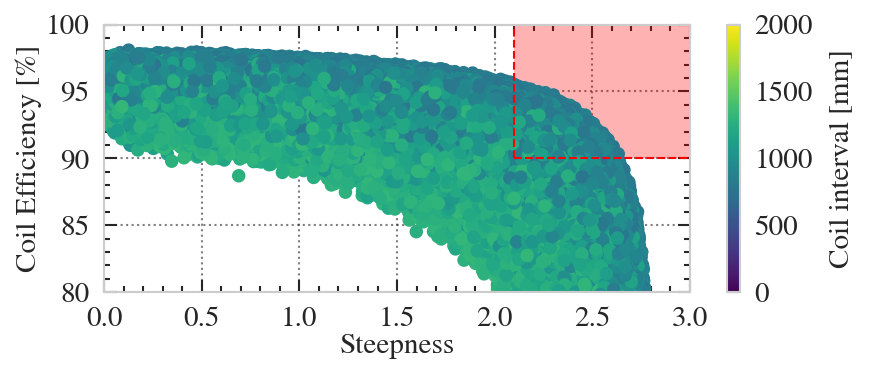

In [ ]:
x = df_pred_1.loc[:,'delta_I1b']
y = (df_pred_1.loc[:,'Coil Efficiency[%]'])
z = df_pred_1.loc[:,'Coil interval[mm]']
# z = df_pred_1.loc[:,'VL1[V(rms)]']


fig1=plt.figure(figsize=(cm2inch(fig_width),cm2inch(fig_height)), dpi=300)
xlim = 2.1 #[mm]
ylim = 90 # %   
upper_right(xlim,ylim)

plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=2000,rasterized=True)
plt.colorbar(label=r"Coil interval [mm]")#Show colar bar at the right side 
plt.xlabel(r"Steepness", labelpad = x_label_pad) 
plt.ylabel(r"Coil Efficiency [%]", labelpad = y_label_pad) 
plt.axis([0, 3, 80, 100])   

df_pred_2=df_pred_1[(df_pred_1['delta_I1b']>xlim)&(df_pred_1['Coil Efficiency[%]']>ylim) ]

# df_pred_2
# fig_update = True
# if fig_update == True:      
  # fig1.savefig("/content/drive/MyDrive/2021_Spring/Report/Shun/ECCE2021_digest/FIG/scatter1.pdf")

127082


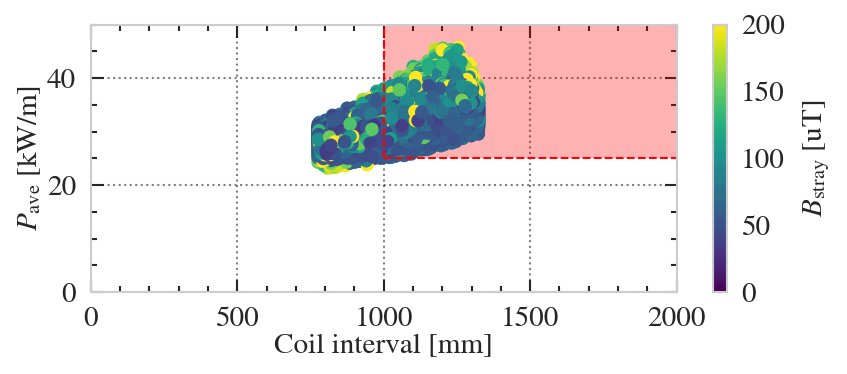

In [ ]:
## x Coil interval, y Pave 40kW, z kdiff
x = df_pred_2.loc[:,'Coil interval[mm]']
y = df_pred_2.loc[:,'Pave[W/m]']/1000
z = df_pred_2.loc[:,'Bstray[uT(rms)]']
# z = df_pred_2.loc[:,'Coil interval[mm]']
fig1=plt.figure(figsize=(cm2inch(fig_width),cm2inch(fig_height)), dpi=300)
xlim = 1000 #coil interval[mm]
ylim = 25 #kW/m 
upper_right(xlim,ylim)

plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=200,rasterized=True)
plt.colorbar(label=r'$B_{\rm stray}~[\rm uT]$')#Show colar bar at the right side 

plt.xlabel(r"Coil interval [mm]",labelpad = x_label_pad) # not shown
plt.ylabel(r"$P_{\rm ave}~[\rm kW/m]$",labelpad = y_label_pad)              

plt.axis([0, 2000, 0, 50])

  
df_pred_3=df_pred_2[(df_pred_2['Coil interval[mm]']>xlim)&(df_pred_2['Pave[W/m]']/1000>ylim) ]
print(len(df_pred_3))
# df_pred_3
# fig1.savefig("/content/drive/MyDrive/2021_Spring/Report/Shun/ECCE2021_digest/FIG/scatter2.pdf")

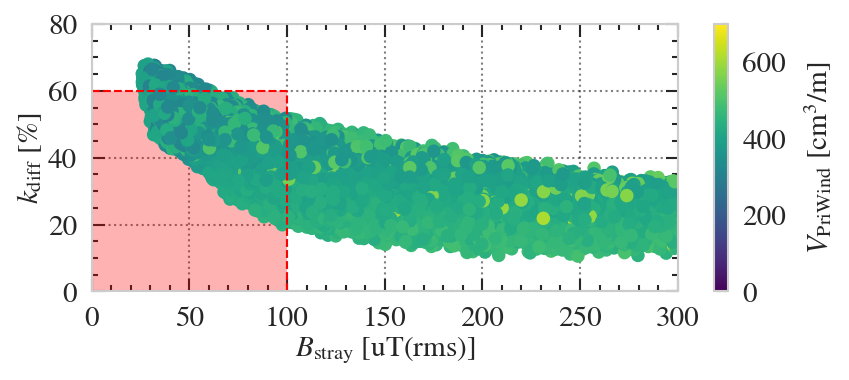

In [ ]:
#x kdiff 50%, y Bstray 50uT, z Pri Winding
# import matplotlib.pyplot as plt
# from matplotlib.cbook import get_sample_data
x = df_pred_3.loc[:,'Bstray[uT(rms)]']
y = df_pred_3.loc[:,'kdiff[%]']
z = df_pred_3.loc[:,'V_PriWind_ave[cm3/m]']
# z = df_pred_3.loc[:,'VL1[V(rms)_True]']

fig1=plt.figure(figsize=(cm2inch(fig_width),cm2inch(fig_height)), dpi=300)
xlim = 100 # [uT(rms)] 
ylim = 60 # % kdiff
lower_left(xlim,ylim)
plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=700,rasterized=True)
plt.colorbar(label=r'$V_{\rm PriWind}~[\rm cm^3/m]$')#Show colar bar at the right side 
# plt.colorbar(label=r'$V_{\rm L1}~[\rm V(rms)]$')#Show colar bar at the right side 

plt.xlabel(r"$B_{\rm stray}~[\rm uT(rms)]$",labelpad = x_label_pad)
plt.ylabel(r"$k_{\rm diff}~[\%]$",labelpad = y_label_pad) 
plt.axis([0, 300, 0, 80]) 

df_pred_4=df_pred_3[(df_pred_3['kdiff[%]']<ylim)&(df_pred_3['Bstray[uT(rms)]']<xlim) ]
# df_pred_4.to_csv(foldername+'/candidate.csv')
# df_pred_4
# fig1.savefig("/content/drive/MyDrive/2021_Spring/Report/Shun/ECCE2021_digest/FIG/scatter3.pdf")

,Length of secondary core[mm],Width of primary core[mm],Coil interval[mm],Length of primary core[mm],Inverter[1/m],V_SecWind[cm3],V_SecCore[cm3],V_PriWind_ave[cm3/m],V_PriCore_ave[cm3/m],kdiff[%],L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH]
79,730.610348,750.000012,1274.734082,1224.999986,0.784477,343.086650,2668.957402,322.226182,3603.692788,59.576452,-0.000002,0.000002,1.919969e-07,7.746512e-07,7.668565e-07,2.934491e-07,5.248583e-07,2.230204,1.513116,50000,2.593822,4972.750976,6934.603996,90.054498,86.130792,332.280296,254.723008,4043.651513,2534.025776,0.501629,2.788584,1.684428,0.167991,68.629339,36184.177333,50000.0,44.245023,12.734273,12,3.0,4.0,128.244797,271.684416,1152.999985,353.912867,49.734096,110.913000,36.000001,138.348740,1869.234110,2028.575802,2187.917623,2347.259393,2506.601117,0.135476,0.137236,0.129983,0.094996,0.043050,0.054764,2531.790861,2535.452743,2545.796983,2551.716430,2550.656105,1164.190571,1164.257253,1163.952793,1168.355707,1174.062478
860,795.006682,625.000008,1248.203519,1200.000037,0.801151,280.107139,3160.178125,319.107168,3004.317891,53.093913,-0.000002,0.000002,3.072840e-07,7.318707e-07,5.541175e-07,5.267075e-07,8.176156e-07,2.178095,1.457199,50000,2.593822,4120.742660,5769.435817,91.758515,88.461128,306.595075,377.968723,2652.603121,2209.235737,0.568787,2.552314,2.475527,0.180833,64.548372,32274.185864,50000.0,43.093858,15.512007,12,3.0,3.0,42.155152,179.295299,1128.000036,376.722501,48.203483,180.697203,36.000001,159.142091,1830.203481,1986.228881,2142.254382,2298.279764,2454.305235,0.145833,0.145440,0.129848,0.090135,0.041777,0.068404,1799.972201,1806.839711,1815.200692,1813.132544,1812.021601,1216.031691,1216.525125,1214.950330,1225.386649,1237.293149
927,750.643480,699.999981,1272.150620,1224.999944,0.786070,322.243405,2817.328169,448.296934,3370.276775,53.129899,-0.000002,0.000002,1.407486e-07,6.809217e-07,6.943740e-07,4.843650e-07,5.764523e-07,2.220739,1.502543,50000,2.593822,4761.579745,6664.415315,90.476841,86.671169,290.836340,277.236415,4668.811190,1972.222664,0.679928,2.190119,1.830176,0.179926,66.678346,34971.968040,50000.0,59.873776,13.285111,12,4.0,4.0,15.287055,249.652883,1128.999943,274.067852,47.150676,209.886494,48.000001,188.287814,1860.650706,2019.669549,2178.688374,2337.707225,2496.725953,0.145102,0.146884,0.137946,0.095210,0.036293,0.068009,1878.619664,1885.438813,1904.048942,1910.612996,1911.072783,832.505085,833.517721,832.963435,837.781207,843.488916
948,682.799759,725.000012,1057.098820,1024.999975,0.945985,304.693580,2331.077557,346.724633,3514.926797,57.024656,-0.000002,0.000001,2.882209e-07,8.305354e-07,5.277236e-07,4.008413e-07,5.800208e-07,2.329872,1.637435,50000,2.593822,4953.410356,6916.283826,90.093179,86.167432,372.172385,312.060581,3256.845652,2465.085868,0.445225,2.447009,2.099100,0.179609,64.425487,32212.743341,50000.0,44.589293,14.094819,12,3.0,4.0,66.850764,235.432214,952.999974,291.550505,32.098846,177.933136,36.000001,145.624627,1551.598879,1683.736232,1815.873549,1948.010974,2080.148217,0.144846,0.143596,0.130461,0.094085,0.045281,0.062248,1820.588218,1825.847288,1837.855136,1847.010545,1848.919012,924.430705,925.199815,925.527688,930.982742,934.339849
971,743.551556,575.000000,1109.446669,1074.999992,0.901350,243.909544,2764.344582,328.223759,2785.735505,56.472044,-0.000003,0.000001,3.300185e-07,8.547660e-07,4.882017e-07,8.649447e-07,8.802875e-07,2.223352,1.505442,50000,2.593822,4559.444239,6369.110943,90.881112,87.261778

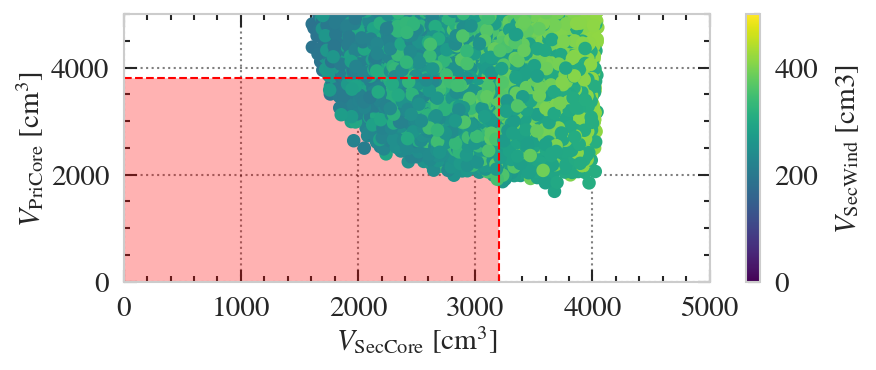

In [ ]:
# x Vseccore, y Vpricore, z n1
x = df_pred_4.loc[:,'V_SecCore[cm3]']
y = df_pred_4.loc[:,'V_PriCore_ave[cm3/m]']
# z = df_pred_4.loc[:,'n2']
z = df_pred_4.loc[:,'V_SecWind[cm3]']
# z = df_pred_4.loc[:,'VL2[V(rms)_True]']
fig1=plt.figure(figsize=(cm2inch(fig_width),cm2inch(fig_height)), dpi=300)
xlim = 3200 # [cm3] 
ylim = 3800 # [cm3/m]
lower_left(xlim,ylim)
plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=500,rasterized=True)
# plt.colorbar(label=r'$n_2$')#Show colar bar at the right side 
# plt.colorbar(label=r'$V_{\rm L2}~[\rm V(rms)]$')#Show colar bar at the right side 
plt.colorbar(label=r'$V_{\rm SecWind}~[\rm cm3]$')#Show colar bar at the right side 

plt.xlabel(r"$V_{\rm SecCore}~[\rm cm^3]$",labelpad = x_label_pad)
plt.ylabel(r"$V_{\rm PriCore}~[\rm cm^3]$",labelpad = y_label_pad) 
plt.axis([0, 5000, 0, 5000]) 

df_pred_5=df_pred_4[(df_pred_4['V_PriCore_ave[cm3/m]']<ylim)&(df_pred_4['V_SecCore[cm3]']<xlim) ]
df_pred_5.to_csv('/content/drive/My Drive/2021_Summer/Python/FocusingOptimization/Fitting/candidate_v1.csv')
df_pred_5
# fig1.savefig("/content/drive/MyDrive/2021_Spring/Report/Shun/ECCE2021_digest/FIG/scatter3.pdf")

In [ ]:
Np = df_pred_5['Np[turn]'].values
Ns = df_pred_5['Ns[turn]'].values
Lp_xs0_ys0 = (df_pred_5['Lp_xs0_ys0[nH]'].values)*10**(-9)*Np**2
Ls_xs0_ys0 = (df_pred_5['Ls_xs0_ys0[nH]'].values)*10**(-9)*Ns**2
k_xs0_ys0 = df_pred_5['k_xs0_ys0'].values
n2 = df_pred_5['n2'].values
n3 = df_pred_5['n3'].values

Req = df_pred_5['Req'].values
I1b_k0 = df_pred_5['I1b[A(rms)]'].values
I2b_k0 = df_pred_5['I2b[A(rms)]'].values

Zref =[L1_x0y0*k0**2*n2*(-I*L2_x0y0*n3*omega0+Req*n2)/L2_x0y0 for (L1_x0y0,L2_x0y0, k0, n2, n3 , Req) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,n2,n3,Req) ] 
VL1 = [abs(I1b*(omega0*L1_x0y0*I + Zref)) for (L1_x0y0,L2_x0y0,I1b,Zref) in zip(Lp_xs0_ys0,Ls_xs0_ys0,I1b_k0,Zref) ] # Vrms
VL2 = [abs(-I2b*omega0*L2_x0y0*I + I*omega0*k0*sqrt(L1_x0y0*L2_x0y0)*I1b) for (L1_x0y0,L2_x0y0,k0,I2b,I1b) in zip(Lp_xs0_ys0,Ls_xs0_ys0,k_xs0_ys0,I2b_k0,I1b_k0) ] #Vrms
df_pred_5.insert(0, 'VL2[V(rms)_True]', VL2)
df_pred_5.insert(0, 'VL1[V(rms)_True]', VL1)
# df_pred_5

,VL1[V(rms)_True],VL2[V(rms)_True],Length of secondary core[mm],Width of primary core[mm],Coil interval[mm],Length of primary core[mm],Inverter[1/m],V_SecWind[cm3],V_SecCore[cm3],V_PriWind_ave[cm3/m],V_PriCore_ave[cm3/m],kdiff[%],L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH]
6079,1728.74068635516,1839.91566244122,783.013610,525.000017,1043.841156,1000.000026,0.958000,259.973698,3065.551570,318.486104,2514.750581,53.242213,-0.000003,0.000001,4.709826e-07,7.949413e-07,5.439270e-07,6.634874e-07,1.045244e-06,2.102895,1.385446,50000,2.593822,4000.092882,5592.337671,91.999814,88.815325,321.518928,452.727129,2035.520173,2088.628735,0.430387,2.575378,2.921661,0.177487,57.978021,28989.010633,50000.0,37.859146,16.976897,12,3.0,3.0,19.002041,128.996233,928.000025,311.682205,43.841130,178.999851,36.000001,185.665703,1525.841094,1656.321261,1786.801413,1917.281599,2047.761728,0.143135,0.139380,0.116677,0.077211,0.036499,0.066927,1317.126728,1325.003791,1334.007923,1331.309556,1331.894096,959.805923,960.891617,959.693048,970.643048,979.490991
10467,1902.34352921776,1346.31809558630,796.383876,775.000002,1077.233297,1049.999984,0.928304,266.340474,3171.136388,346.557069,3777.036934,47.698313,-0.000003,0.000001,4.957952e-07,8.638275e-07,5.341505e-07,8.493806e-07,7.275517e-07,2.240258,1.524563,50000,2.593822,3577.280610,4985.685308,92.845439,90.028629,372.202202,356.556383,2212.428327,1703.633921,0.333412,1.856567,2.362072,0.223371,57.715555,28857.777287,50000.0,48.100295,15.066215,12,3.0,3.0,28.013195,109.797266,977.999983,322.672116,27.233313,304.588173,36.000001,186.855880,1584.233266,1718.887423,1853.541653,1988.195872,2122.849899,0.180138,0.174320,0.149249,0.102627,0.049650,0.094215,1236.656171,1239.792260,1250.086176,1255.327866,1260.540837,994.046635,994.154259,994.885184,1008.032905,1017.746739
11101,1925.60808460867,1914.02939048316,754.263721,699.999990,1073.600287,1024.999975,0.931445,265.045048,2844.568802,358.323768,3341.560078,46.017543,-0.000002,0.000002,3.648100e-07,6.798933e-07,4.921654e-07,5.629368e-07,7.972861e-07,2.250672,1.536659,50000,2.593822,3918.537022,5505.803597,92.162926,88.988393,294.311231,394.755794,2321.098120,2240.092677,0.691963,2.416298,2.619956,0.205355,58.436508,29218.253763,50000.0,47.501631,15.852739,12,3.0,3.0,1.616956,269.039456,952.999974,359.835789,48.600312,213.863311,36.000001,147.213966,1568.100304,1702.300304,1836.500389,1970.700483,2104.900519,0.165609,0.161345,0.138848,0.094380,0.043757,0.089400,1640.761136,1648.247109,1663.333024,1674.737752,1672.121720,1180.582034,1181.799580,1180.659026,1193.540755,1201.526969
13101,1545.25013291610,1822.22720465229,773.075202,724.999986,1029.239949,1024.999975,0.971591,271.744202,2988.226339,353.064403,3610.066670,47.190118,-0.000002,0.000002,4.595786e-07,6.757579e-07,5.778133e-07,5.395264e-07,8.239265e-07,2.152286,1.431462,50000,2.593822,3328.432467,4670.280513,93.343135,90.659439,279.733889,372.234202,1914.784694,2137.747720,0.673111,2.527129,2.425939,0.223073,59.416022,29708.011005,50000.0,50.751608,15.393884,12,3.0,3.0,31.315492,140.377818,952.999974,366.656209,4.239974,260.995592,36.000001,153.209496,1523.739945,1652.395031,1781.050022,1909.704943,2038.359934,0.179897,0.174915,0.149510,0.107416,0.056458,0.095004,1424.077287,1434.279060,1445.925952,1455.287661,1459.360245,1194.810068,1195.743506,1195.442221,1208.351777,1214.022151
19220,1966.30266329942,1681.15196945875,715.255159,775.000010,1007.207977,975.000017,0.992844,246.794

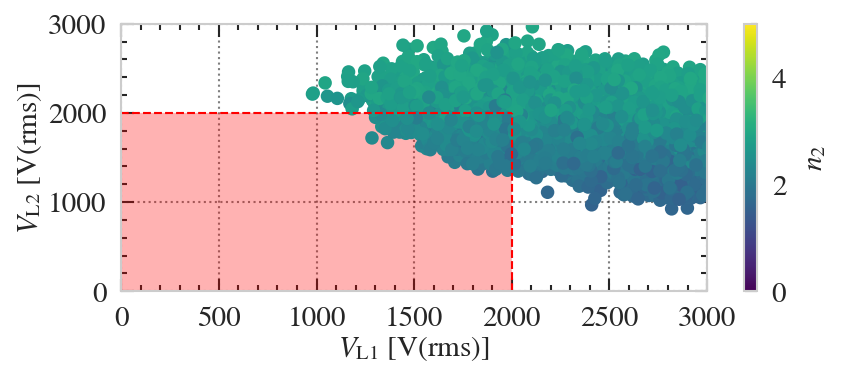

In [ ]:
# x Vseccore, y Vpricore, z n1
x = df_pred_5.loc[:,'VL1[V(rms)_True]']
y = df_pred_5.loc[:,'VL2[V(rms)_True]']
z = df_pred_5.loc[:,'n2']
# z = df_pred_4.loc[:,'VL2[V(rms)_True]']
fig1=plt.figure(figsize=(cm2inch(fig_width),cm2inch(fig_height)), dpi=300)
xlim = 2000 # V 
ylim = 2000 # V
lower_left(xlim,ylim)
plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=5,rasterized=True)
# plt.colorbar(label=r'$n_2$')#Show colar bar at the right side 
plt.colorbar(label=r'$n_2$')#Show colar bar at the right side 

plt.xlabel(r"$V_{\rm L1}~[\rm V(rms)]$",labelpad = x_label_pad)
plt.ylabel(r"$V_{\rm L2}~[\rm V(rms)]$",labelpad = y_label_pad) 
plt.axis([0, 3000, 0, 3000]) 
df_pred_6=df_pred_5[(df_pred_5['VL2[V(rms)_True]']<ylim)&(df_pred_5['VL1[V(rms)_True]']<xlim) ]
# df_pred_6=df_pred_5[(df_pred_5['VL2[V(rms)_True]']<ylim)&(df_pred_5['VL1[V(rms)_True]']<xlim)&(df_pred_5['I1b[A(rms)]']<300)&(df_pred_5['I2b[A(rms)]']<300) ]

# df_pred_6.to_csv('/content/drive/My Drive/2021_Summer/Python/FocusingOptimization/Fitting/candidate_20210824.csv')
df_pred_6
# fig1.savefig("/content/drive/MyDrive/2021_Spring/Report/Shun/ECCE2021_digest/FIG/scatter3.pdf")

,VL1[V(rms)_True],VL2[V(rms)_True],Length of secondary core[mm],Width of primary core[mm],Coil interval[mm],Length of primary core[mm],Inverter[1/m],V_SecWind[cm3],V_SecCore[cm3],V_PriWind_ave[cm3/m],V_PriCore_ave[cm3/m],kdiff[%],L1sa,C1sa,C1sb,C1pa,C2sa,C2sb,C2pa,delta_I1b,delta_P,Pout[W],Req,Loss coil[W],Loss total[W],Coil Efficiency[%],Total Efficiency[%],I1b[A(rms)],I2b[A(rms)],VL1[V(rms)],VL2[V(rms)],n1,n2,n3,k1,Pratio[%],Pave[W/m],Pout_xs0[W],Bstray[uT(rms)],ds[mm],dp[mm],Np[turn],Ns[turn],ax[mm],lpx[mm],lpy[mm],ls[mm],p[mm],wpx[mm],wpy[mm],ws[mm],ys0[mm],ys1[mm],ys2[mm],ys3[mm],ys4[mm],k_xs0_ys0,k_xs0_ys1,k_xs0_ys2,k_xs0_ys3,k_xs0_ys4,k_xs1_ys0,Lp_xs0_ys0[nH],Lp_xs0_ys1[nH],Lp_xs0_ys2[nH],Lp_xs0_ys3[nH],Lp_xs0_ys4[nH],Ls_xs0_ys0[nH],Ls_xs0_ys1[nH],Ls_xs0_ys2[nH],Ls_xs0_ys3[nH],Ls_xs0_ys4[nH]
445510,1838.74179321915,1844.64119212782,781.70192,749.999992,1014.647421,1000.000026,0.985564,338.010368,3055.289462,345.823779,3695.865164,52.454282,-0.000002,0.000002,3.883040e-07,7.202013e-07,7.303140e-07,3.958616e-07,6.756595e-07,2.121307,1.402126,50000,2.593822,3258.526189,4550.255727,93.482948,90.899489,293.84033,297.205787,2180.844257,2229.399657,0.580432,2.706808,1.925163,0.217609,61.140868,30570.434145,50000.0,37.566049,13.755256,12,3.0,4.0,79.346144,165.794826,928.000025,288.254371,14.647396,212.75644,36.000001,196.723775,1496.647438,1623.478278,1750.309307,1877.140163,2003.971065,0.175491,0.170906,0.149618,0.107561,0.056433,0.083438,1544.087636,1550.58582,1561.510786,1565.697573,1568.134604,877.832978,878.996675,879.941631,887.882196,891.548014


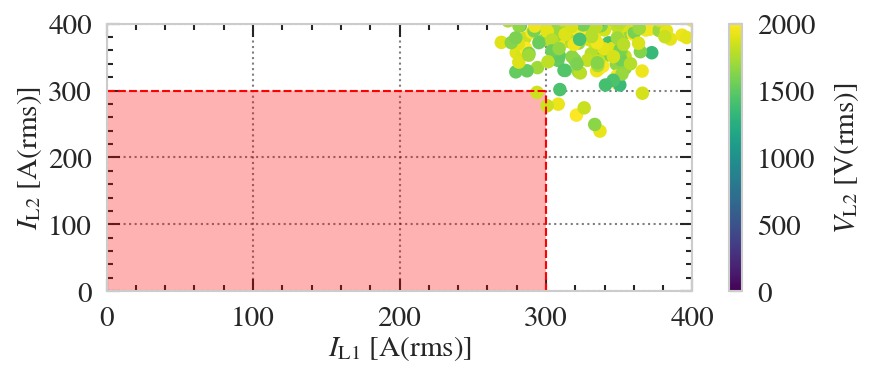

In [ ]:
# x Vseccore, y Vpricore, z n1
x = df_pred_6.loc[:,'I1b[A(rms)]']
y = df_pred_6.loc[:,'I2b[A(rms)]']
z = df_pred_6.loc[:,'VL2[V(rms)_True]']
# z = df_pred_4.loc[:,'VL2[V(rms)_True]']
fig1=plt.figure(figsize=(cm2inch(fig_width),cm2inch(fig_height)), dpi=300)
xlim = 300 # A 
ylim = 300 # A
lower_left(xlim,ylim)
plt.scatter(x, y, c=z, s=marker_size, cmap ='viridis', vmin = 0, vmax=2000,rasterized=True)
# plt.colorbar(label=r'$n_2$')#Show colar bar at the right side 
plt.colorbar(label=r'$V_{\rm L2}~[\rm V(rms)]$')#Show colar bar at the right side 

plt.xlabel(r"$I_{\rm L1}~[\rm A(rms)]$",labelpad = x_label_pad)
plt.ylabel(r"$I_{\rm L2}~[\rm A(rms)]$",labelpad = y_label_pad) 
plt.axis([0, 400, 0, 400]) 
df_pred_7=df_pred_6[(df_pred_6['I2b[A(rms)]']<ylim)&(df_pred_6['I1b[A(rms)]']<xlim) ]
# df_pred_6=df_pred_5[(df_pred_5['VL2[V(rms)_True]']<ylim)&(df_pred_5['VL1[V(rms)_True]']<xlim)&(df_pred_5['I1b[A(rms)]']<300)&(df_pred_5['I2b[A(rms)]']<300) ]

df_pred_7.to_csv('/content/drive/My Drive/2021_Summer/Python/FocusingOptimization/Fitting/candidate_20210824.csv')
df_pred_7
# fig1.savefig("/content/drive/MyDrive/2021_Spring/Report/Shun/ECCE2021_digest/FIG/scatter3.pdf")